# Прогнозные модели для отбора бурёнок в поголовье

В IT-компанию, выполняющую на заказ проекты по машинному обучению, обратился фермер, владелец молочного хозяйства. Он хочет купить бурёнок, чтобы расширить поголовье стада коров, для этого он заключил выгодный контракт с некой ассоциацией пастбищ. Фермер определяет качество молока по своей строгой методике, при этом ему нужно выполнять свой план развития молочного хозяйства; он хочет, чтобы каждая бурёнка давала не менее 6000 кг молока в год, а надой был вкусным. Целью проекта является создание модели машинного обучения, которая поможет фермеру управлять рисками и принимать объективное решение о покупке

---

**Цель исследования:** построить две прогнозные модели: первая будет прогнозировать возможный удой у коровы, а вторая — рассчитывать вероятность получить от коровы вкусное молоко

---

**План выполнения работы:**

- загрузка и предварительное изучение данных
- предобработка данных
- исследовательский анализ данных
- корреляционный анализ данных
- подготовка данных к обучению
- обучение моделей линейной регрессии, их сравнение и применение
- обучение модели логистической регресии, её тестирование и применение

Каждый шаг исследования заканчивается промежуточным выводом. В конце исследования даётся общий подробный вывод

---

- таблица `ferma_main` содержит данные о стаде фермера на текущий момент, `ferma_dad` — имя папы каждой коровы в этом стаде. Таблица `cow_buy` хранит данные о коровах, которых фермер хочет изучить перед покупкой
- с помощью прогнозных моделей необходимо отобрать коров по двум критериям: средний удой за год должен быть не менее 6000 кг, а молоко — вкусным

---

In [1]:
# установка широкоформатного jupyter

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# импорт библиотек

import os
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score,
    mean_absolute_error,
    mean_squared_error
)

warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [3]:
# константы

FERMA_MAIN = 'D:\\datasets\\cows\\ferma_main.csv'
FERMA_DAD = 'D:\\datasets\\cows\\ferma_dad.csv'
COW_BUY = 'D:\\datasets\\cows\\cow_buy.csv'

PATHS = [FERMA_MAIN, FERMA_DAD, COW_BUY]
NAMES = ['ferma_main', 'ferma_dad', 'cow_buy']

RANDOM_STATE = 42
TEST_SIZE = 0.25
TARGET = 'milk_amount'

---

In [4]:
def load_datasets(PATHS):
    
    """
    Функция load_datasets загружает csv-файлы, пути к которым хранятся в переменной PATHS
    
    Аргументы:
    PATHS (list) : список путей к файлам
    
    Возвращает:
    datasets (list) : список, содержащий в себе все загруженные таблицы
    
    """
    
    datasets = []

    for path in PATHS:
        try:
            data = pd.read_csv(path, sep=';', decimal=',')
            filename = os.path.basename(path)
            print(f'Файл {filename} успешно загружен!')
            datasets.append(data)
        except Exception as error:
            print(f'Упс, что-то пошло не так при загрузке файла {os.path.basename(path)}! Текст ошибки: {repr(error)}')

    return datasets

In [5]:
def get_info(data):
    
    """
    Функция get_info выводит на экран пять случайных строк таблицы и общую информацию, полученную с помощью info()

    Аргументы:
    data (DataFrame): датафрейм

    """
    
    print('Пять случайных строк таблицы:')
    display(data.sample(5))
    print(' ')
    print('Общая информация о таблице:')
    print(' ')
    print(data.info())

In [6]:
def preprocess(data, data_name):
    
    """
    Функция preprocess выводит на экран количество дубликатов и пропусков в датафрейме

    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """
    
    for col in data:
        isna_count = data[col].isna().sum()
        if isna_count > 0:
            print(f'Пропусков найдено в столбце {col}: {isna_count}')
    isna_total = data.isna().sum().sum()
    if isna_total == 0:
        print(f'В таблице {data_name} не найдено ни одного пропуска!')
        
    duplicates_count = data.duplicated().sum()
    if duplicates_count > 0:
        print(f'Дубликатов найдено в таблице {data_name}: {duplicates_count}')
    else:
        print(f'В таблице {data_name} не найдено ни одного дубликата!')

In [7]:
def hidden_duplicates(data):
        
    """
    Функция hidden_duplicates сохраняет все столбцы типа object и/или category в переменную columns, 
    выводит на экран уникальные значения в каждом из этих столбцов 

    Аргументы:
    data (DataFrame): датафрейм
    
    """
    
    columns = data.select_dtypes(include=['object', 'category']).columns
    
    for column in columns:
        unique_values = data[column].unique()
        print(f'Уникальные значения в столбце {column}: {unique_values}')

In [8]:
def value_counts(data, col, data_name):
                
    """
    Функция value_counts выводит на экран числовое распределение данных в категориальном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Распределение данных в столбце {col} таблицы {data_name}:')
    print(' ')
    print(data[col].value_counts())

In [9]:
def describe(data, col, data_name):
                    
    """
    Функция describe выводит на экран числовое описание данных в количественном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Числовое описание столбца {col} таблицы {data_name}:')
    print(' ')
    print(data[col].describe())

In [10]:
def barplot(data, col, xlabel, title):
            
    """
    Функция barplot выводит на экран готовую столбчатую диаграмму размером 8х4 дюйма, 
    содержащую значения относительно частоты встречаемых значений

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    xlabel (str) : подпись оси Х
    title (str) : название графика
    
    """
    
    sns.set(style='darkgrid')
    plt.figure(figsize=(7, 4))

    data_new = data[col].value_counts(normalize=True)
    data_new_ = data_new.reset_index()
    data_new_.columns = [col, 'count']
    
    unique_values = len(data_new_)
    palette = sns.color_palette('Blues', unique_values)
    
    ax = sns.barplot(x=col, y='count', data=data_new_, hue=col, dodge=False, palette=palette, legend=False)

    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height() * 100) + '%',
                fontsize=8, ha='center', va='bottom')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel('Частота')

    plt.show()

In [11]:
def compare_barplots(data1, col1, xlabel1, title1, data2, col2, xlabel2, title2):
    
    """
    Функция compare_barplots выводит на экран две столбчатые диаграммы

    Аргументы:
    data1 (DataFrame) : первый датафрейм
    col1 (str) : название столбца первого датафрейма
    xlabel1 (str) : подпись оси Х для первого графика
    title1 (str) : название первого графика
    data2 (DataFrame) : второй датафрейм
    col2 (str) : название столбца второго датафрейма
    xlabel2 (str) : подпись оси Х для второго графика
    title2 (str) : название второго графика
    
    """
    
    sns.set(style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    max_y = 0

    for ax, data, col, xlabel, title in zip(
        axes, 
        [data1, data2], 
        [col1, col2], 
        [xlabel1, xlabel2], 
        [title1, title2]
    ):
        count_data = data[col].value_counts()
        percent_data = data[col].value_counts(normalize=True)
        count_data_ = count_data.reset_index()
        count_data_.columns = [col, 'count']
        percent_data_ = percent_data.reset_index()
        percent_data_.columns = [col, 'percent']
        data_new_ = count_data_.merge(percent_data_, on=col)

        unique_values = len(data_new_)
        palette = sns.color_palette('Blues', unique_values)

        sns.barplot(x=col, y='count', data=data_new_, hue=col, dodge=False, palette=palette, ax=ax, legend=False)

        for i, p in enumerate(ax.patches):
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f"{data_new_['percent'].iloc[i]:.0%}",
                    fontsize=8, ha='center', va='bottom')

        ax.set_title(title, fontsize=16)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Количество сотрудников')

        max_y = max(max_y, count_data_['count'].max())

    for ax in axes:
        ax.set_ylim(0, max_y * 1.1)
        
    plt.tight_layout()
    plt.show()

In [12]:
def hist_violin(data, col, bins, title, xlabel):
                        
    """
    Функция hist_violin выводит на экран гистограмму и скрипичную диаграмму для количественного столбца датафрейма

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    bins (int) : количество корзин для построения гистограммы
    title (str) : название графика
    xlabel (str) : подпись оси X у обоих графиков
    
    """
    
    sns.set(style='darkgrid', palette='pastel')
    fig, ax = plt.subplots(1, 2, figsize=(16, 3))
    
    sns.histplot(data=data, x=col, kde=True, bins=bins, color='indianred')
    plt.title('Гистограмма')
    plt.ylabel('Количество наблюдений')
    plt.xlabel(xlabel)
    ax[0].grid()
    
    sns.violinplot(x=data[col], ax=ax[0], color='skyblue')
    ax[0].set_title('Скрипичная диаграмма')
    ax[0].set_ylabel('Значения')
    ax[0].set_xlabel(xlabel)
    ax[0].grid()
    
    ax_title = fig.add_axes([0.5, 1.0, 0.1, 0.1])
    ax_title.set_axis_off()
    ax_title.text(0, 0, title, ha='center', va='center', fontsize=16)

    plt.show()

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Загрузка и предварительное изучение данных
</div>

---

In [13]:
# применим функцию load_datasets()

DATASETS = load_datasets(PATHS)

Файл ferma_main.csv успешно загружен!
Файл ferma_dad.csv успешно загружен!
Файл cow_buy.csv успешно загружен!


In [14]:
# сохраним таблицы в переменные с соответствующими им именами

for name, dataset in zip(NAMES, DATASETS):
    globals()[name] = dataset

---

In [15]:
# изучим общую информацию о таблице ferma_main

get_info(ferma_main)

Пять случайных строк таблицы:


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
402,403,6153,13.5,2169,0.94,Вис Бик Айдиал,Равнинное,Айдиал,3.59,3.078,не вкусно,более_2_лет
78,79,6037,14.4,2106,0.93,РефлешнСоверинг,Холмистое,Айдиалл,3.73,3.078,вкусно,более_2_лет
462,463,6345,16.1,1958,0.93,РефлешнСоверинг,Холмистое,Соверин,3.71,3.073,не вкусно,более_2_лет
544,545,5380,12.4,1875,0.84,РефлешнСоверинг,Равнинное,Соверин,3.63,3.073,не вкусно,менее_2_лет
318,319,6741,14.6,1881,0.93,Вис Бик Айдиал,Равнинное,Айдиал,3.74,3.077,не вкусно,более_2_лет


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634

- таблица `ferma_main` содержит 634 строки и 12 столбцов

In [16]:
# изучим общую информацию о таблице ferma_dad

get_info(ferma_dad)

Пять случайных строк таблицы:


,id,Имя Папы
538,539,Соловчик
211,212,Буйный
284,285,Барин
96,97,Барин
201,202,Барин


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None


- таблица `ferma_dad` содержит 629 строк и 2 столбца

In [17]:
# изучим общую информацию о таблице cow_buy

get_info(cow_buy)

Пять случайных строк таблицы:


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
15,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
18,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.34,3.069,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
None


- таблица `cow_buy` содержит 20 строк и 7 столбцов

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
    
Загруженные данные соответствуют описанию, типы данных во всех трёх таблицах определены верно, пропусков в них не обнаружено. Названия столбцов в каждой из таблиц требуют переименования
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Предобработка данных
</div>

---

In [18]:
def cols_list(data, data_name):
    
    """
    Функция cols_list выводит на экран список столбцов датафрейма
    
    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """

    print(f'Cписок столбцов в таблице {data_name}:\n\n', data.columns.to_list())

---

### `ferma_main`

In [19]:
# переименуем столбцы в таблице ferma_main

ferma_main_new_cols = ['id', 'milk_amount', 'eke', 'raw_protein', 'spo', 'breed', 'pasture_type', 'dad_breed', 'fat_percent', 'protein_percent', 'is_tasty', 'age']
ferma_main.columns = ferma_main_new_cols

In [20]:
# проверим результат

cols_list(ferma_main, 'ferma_main')

Cписок столбцов в таблице ferma_main:

 ['id', 'milk_amount', 'eke', 'raw_protein', 'spo', 'breed', 'pasture_type', 'dad_breed', 'fat_percent', 'protein_percent', 'is_tasty', 'age']


In [21]:
# применим функцию preprocess

preprocess(ferma_main, 'ferma_main')

В таблице ferma_main не найдено ни одного пропуска!
Дубликатов найдено в таблице ferma_main: 5


In [22]:
# удалим 5 обнаруженных строк-дубликатов

ferma_main = ferma_main.drop_duplicates()

In [23]:
# проверим таблицу на наличие неявных дубликатов

hidden_duplicates(ferma_main)

Уникальные значения в столбце breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения в столбце pasture_type: ['Равнинное' 'Равнинные' 'Холмистое']
Уникальные значения в столбце dad_breed: ['Айдиал' 'Соверин' 'Айдиалл']
Уникальные значения в столбце is_tasty: ['вкусно' 'не вкусно']
Уникальные значения в столбце age: ['более_2_лет' 'менее_2_лет']


In [24]:
# заменим неявные дубликаты в столбцах pasture_type и dad_breed

ferma_main.loc[ferma_main['pasture_type'] == 'Равнинные', 'pasture_type'] = 'Равнинное'
ferma_main.loc[ferma_main['dad_breed'] == 'Айдиалл', 'dad_breed'] = 'Айдиал'

In [25]:
# исправим разное написание одинаковых пород в столбцах breed и dad_breed

ferma_main.loc[:, 'breed'] = ferma_main['breed'].replace({
    'Вис Бик Айдиал': 'Айдиал',
    'РефлешнСоверинг': 'Соверин'
})

In [26]:
# проверим результат

hidden_duplicates(ferma_main)

Уникальные значения в столбце breed: ['Айдиал' 'Соверин']
Уникальные значения в столбце pasture_type: ['Равнинное' 'Холмистое']
Уникальные значения в столбце dad_breed: ['Айдиал' 'Соверин']
Уникальные значения в столбце is_tasty: ['вкусно' 'не вкусно']
Уникальные значения в столбце age: ['более_2_лет' 'менее_2_лет']


### `ferma_dad`

In [27]:
# переименуем столбец в таблице ferma_dad

ferma_dad = ferma_dad.rename(columns={'Имя Папы':'dad_name'})

In [28]:
# проверим результат

cols_list(ferma_dad, 'ferma_dad')

Cписок столбцов в таблице ferma_dad:

 ['id', 'dad_name']


In [29]:
# применим функцию preprocess

preprocess(ferma_dad, 'ferma_dad')

В таблице ferma_dad не найдено ни одного пропуска!
В таблице ferma_dad не найдено ни одного дубликата!


In [30]:
# проверим таблицу на наличие неявных дубликатов

hidden_duplicates(ferma_dad)

Уникальные значения в столбце dad_name: ['Буйный' 'Соловчик' 'Барин' 'Геркулес']


### `cow_buy`

In [31]:
# переименуем столбцы в таблице cow_buy

cow_buy_new_cols = ['breed', 'pasture_type', 'dad_breed', 'dad_name', 'current_fat_percent', 'current_protein_percent', 'age']
cow_buy.columns = cow_buy_new_cols

In [32]:
# проверим результат

cols_list(cow_buy, 'cow_buy')

Cписок столбцов в таблице cow_buy:

 ['breed', 'pasture_type', 'dad_breed', 'dad_name', 'current_fat_percent', 'current_protein_percent', 'age']


In [33]:
# применим функцию preprocess

preprocess(cow_buy, 'cow_buy')

В таблице cow_buy не найдено ни одного пропуска!
Дубликатов найдено в таблице cow_buy: 4


In [34]:
# удалим 4 обнаруженные строки-дубликата

cow_buy = cow_buy.drop_duplicates()

In [35]:
# проверим таблицу на наличие неявных дубликатов

hidden_duplicates(cow_buy)

Уникальные значения в столбце breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения в столбце pasture_type: ['холмистое' 'равнинное']
Уникальные значения в столбце dad_breed: ['Айдиал' 'Соверин']
Уникальные значения в столбце dad_name: ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
Уникальные значения в столбце age: ['более_2_лет' 'менее_2_лет']


In [36]:
# исправим разное написание одинаковых пород в столбцах breed и dad_breed

cow_buy.loc[:, 'breed'] = cow_buy['breed'].replace({
    'Вис Бик Айдиал': 'Айдиал',
    'РефлешнСоверинг': 'Соверин'
})

In [37]:
# исправим значения в столбце pasture_type

cow_buy.loc[:, 'pasture_type'] = cow_buy['pasture_type'].replace({
    'холмистое':'Холмистое',
    'равнинное':'Равнинное'
})

In [38]:
# проверим результат

hidden_duplicates(cow_buy)

Уникальные значения в столбце breed: ['Айдиал' 'Соверин']
Уникальные значения в столбце pasture_type: ['Холмистое' 'Равнинное']
Уникальные значения в столбце dad_breed: ['Айдиал' 'Соверин']
Уникальные значения в столбце dad_name: ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
Уникальные значения в столбце age: ['более_2_лет' 'менее_2_лет']


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
    
Предобработка данных завершена. В каждой из трёх таблиц столбцы и их значения приведены к одинаковому написанию, исправлены неявные дубликаты
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Исследовательский анализ данных
</div>

---

Посмотрим на числовые описания всех столбцов в таблицах `ferma_main` и `cow_buy`, так как таблица `ferma_dad` содержит только категориальные признаки. Для удобства визуализации транспонируем результаты функции describe()

In [39]:
# посмотрим на числовое описание всех признаков в таблице ferma_main

ferma_main.describe().T

,count,mean,std,min,25%,50%,75%,max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000
milk_amount,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
eke,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
raw_protein,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
spo,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
fat_percent,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
protein_percent,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


In [40]:
# посмотрим на числовое описание всех признаков в таблице cow_buy

cow_buy.describe().T

,count,mean,std,min,25%,50%,75%,max
current_fat_percent,16.0,3.571875,0.141620,3.340,3.4150,3.5850,3.69250,3.770
current_protein_percent,16.0,3.068250,0.011264,3.046,3.0595,3.0735,3.07675,3.081


Видим аномальный максимум в столбце `milk_amount`, он составляет 45616 кг молока при среднем удое в 6188 кг и медиане в 6133 кг. Удой с одной коровы просто не может быть такого размера, от этого выброса необходимо избавиться. Во всех остальных столбцах обеих таблиц распределение данных выглядит нормально

In [41]:
# избавимся от найденного выброса

ferma_main = ferma_main.query('milk_amount < 10000')

---

## Таблица `ferma_main`

### `milk_amount`

In [42]:
# выведем на экран числовое распределение данных в столбце milk_amount

describe(ferma_main, 'milk_amount', 'ferma_main')

Числовое описание столбца milk_amount таблицы ferma_main:
 
count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: milk_amount, dtype: float64


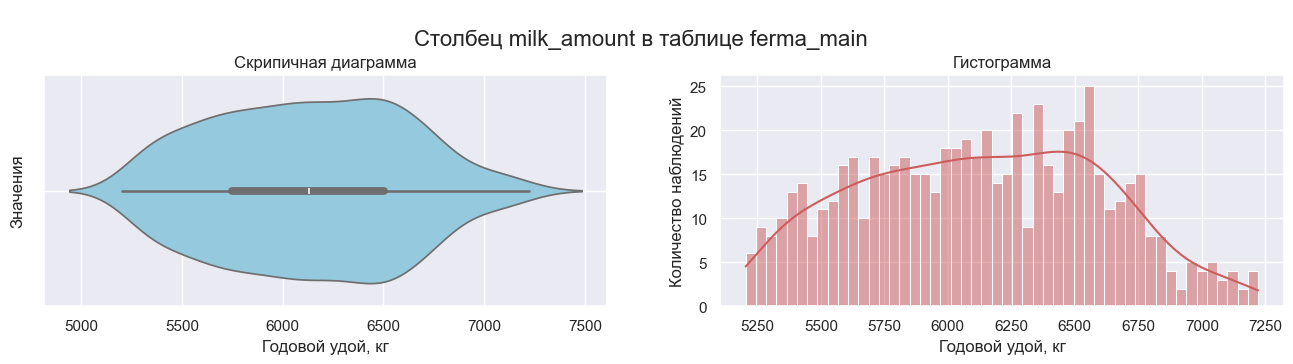

In [43]:
# построим гистограмму и скрипичную диаграмму для столбца milk_amount

hist_violin(ferma_main, 'milk_amount', 50, 'Столбец milk_amount в таблице ferma_main ', 'Годовой удой, кг')

Большинство коров не дают больше 6500 кг молока в год. Минимальный удой составляет 5204 кг, а максимальный — 7222 кг. В среднем, коровы фермера дают 6125 кг молока в год

### `eke`

In [44]:
# выведем на экран числовое распределение данных в столбце eke

describe(ferma_main, 'eke', 'ferma_main')

Числовое описание столбца eke таблицы ferma_main:
 
count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: eke, dtype: float64


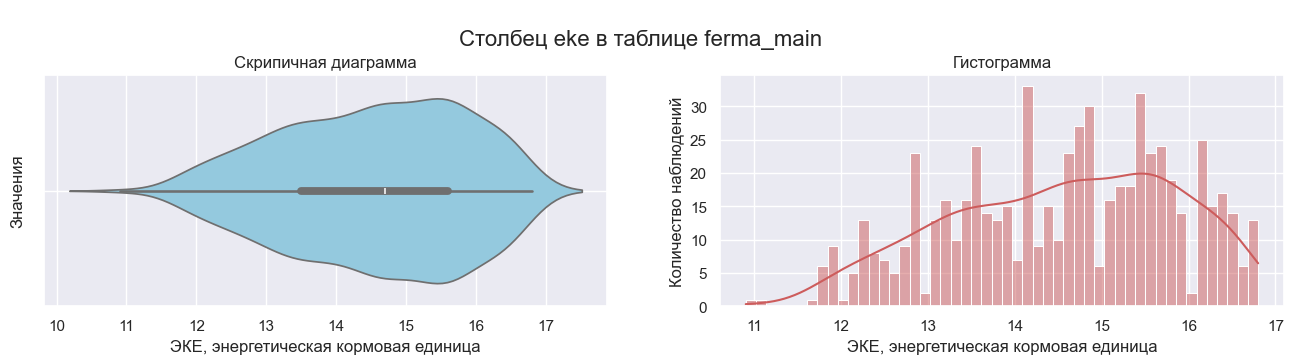

In [45]:
# построим гистограмму и скрипичную диаграмму для столбца eke

hist_violin(ferma_main, 'eke', 50, 'Столбец eke в таблице ferma_main ', 'ЭКЕ, энергетическая кормовая единица')

Основное количество данных сосредоточено в диапазоне от 13,5 до ~15,6 кормовых единиц, минимум — 10.9 кормовых единиц, максимум — 16.8

### `spo`

In [46]:
# выведем на экран числовое распределение данных в столбце spo

describe(ferma_main, 'spo', 'ferma_main')

Числовое описание столбца spo таблицы ferma_main:
 
count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: spo, dtype: float64


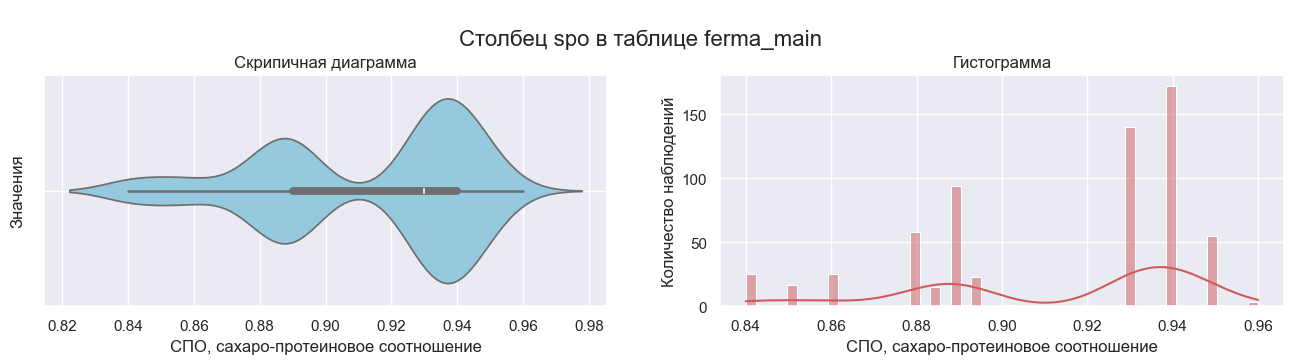

In [47]:
# построим гистограмму и скрипичную диаграмму для столбца spo

hist_violin(ferma_main, 'spo', 50, 'Столбец spo в таблице ferma_main ', 'СПО, сахаро-протеиновое соотношение')

Видим два заметных пика в данных. Это связано со стандартизацией на производстве корма. Данные лежат в диапазоне от 0.84 до 0.96

### `fat_percent`

In [48]:
# выведем на экран числовое распределение данных в столбце fat_percent

describe(ferma_main, 'fat_percent', 'ferma_main')

Числовое описание столбца fat_percent таблицы ferma_main:
 
count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fat_percent, dtype: float64


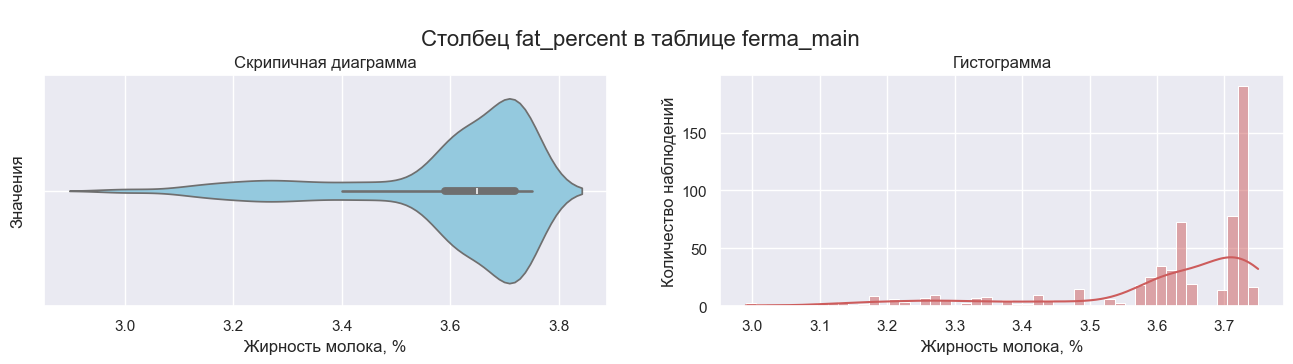

In [49]:
# построим гистограмму и скрипичную диаграмму для столбца fat_percent

hist_violin(ferma_main, 'fat_percent', 50, 'Столбец fat_percent в таблице ferma_main ', 'Жирность молока, %')

Жирность молока тоже стандартизирована, поэтому мы видим, что данные не однородны, а имеют всплески или пики. Основное количество молока имеет жирность в диапазоне между 3.59% и 3.72%. Количество коров, чьё молоко имеет менее 3.5% жирности, в этих данных не считается выбросом

### `protein_percent`

In [50]:
# выведем на экран числовое распределение данных в столбце protein_percent

describe(ferma_main, 'protein_percent', 'ferma_main')

Числовое описание столбца protein_percent таблицы ferma_main:
 
count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein_percent, dtype: float64


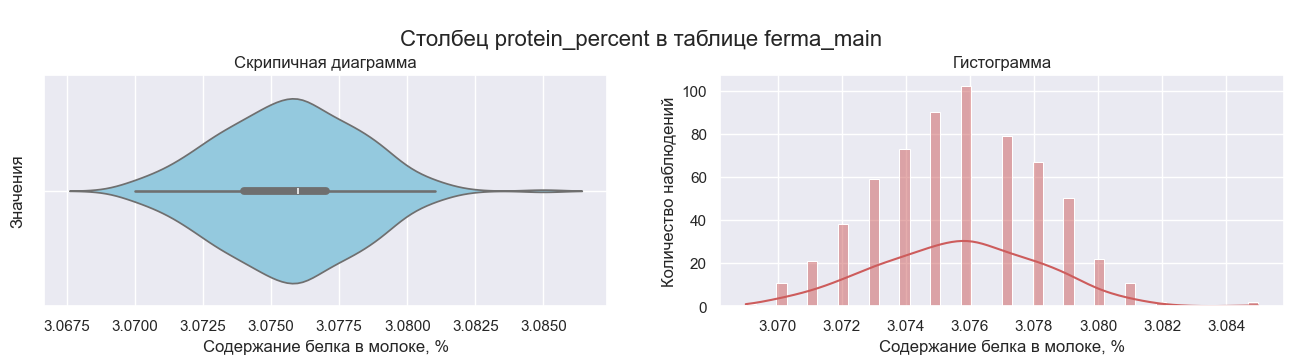

In [51]:
# построим гистограмму и скрипичную диаграмму для столбца protein_percent

hist_violin(ferma_main, 'protein_percent', 50, 'Столбец protein_percent в таблице ferma_main ', 'Содержание белка в молоке, %')

Это распределение можно назвать нормальным — данные о содержании белка в молоке равномерно распределены в диапазоне от 3.69% до 3.85%. По правой стороне обоих графиков видим нечто, похожее на выброс. Удалять мы его не будем, так как значение выглядит реалистично. Вполне возможно, что какая-то коровка даёт молоко с высоким содержанием белка в молоке — 3.08. Это может зависеть от её здоровья и каких-то ещё индивидуальных характеристик

### `pasture_type`

In [52]:
# выведем на экран числовое распределение данных в столбце pasture_type

value_counts(ferma_main, 'pasture_type', 'ferma_main')

Распределение данных в столбце pasture_type таблицы ferma_main:
 
pasture_type
Холмистое    350
Равнинное    278
Name: count, dtype: int64


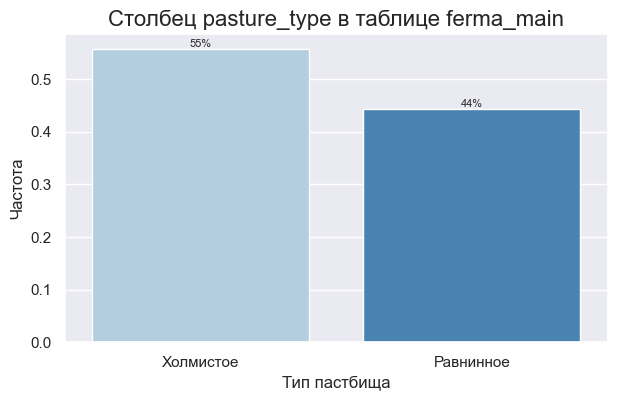

In [53]:
# выведем столбчатую диаграмму для столбца pasture_type в таблице ferma_main

barplot(ferma_main, 'pasture_type', 'Тип пастбища', 'Столбец pasture_type в таблице ferma_main')

Холмистые пастбища преобладают над равнинными по количеству в этих данных

### `breed` и `dad_breed`

In [54]:
# выведем на экран числовое распределение данных в столбцах breed и dad_breed

value_counts(ferma_main, 'breed', 'ferma_main')
print(' ')
value_counts(ferma_main, 'dad_breed', 'ferma_main')

Распределение данных в столбце breed таблицы ferma_main:
 
breed
Айдиал     372
Соверин    256
Name: count, dtype: int64
 
Распределение данных в столбце dad_breed таблицы ferma_main:
 
dad_breed
Айдиал     317
Соверин    311
Name: count, dtype: int64


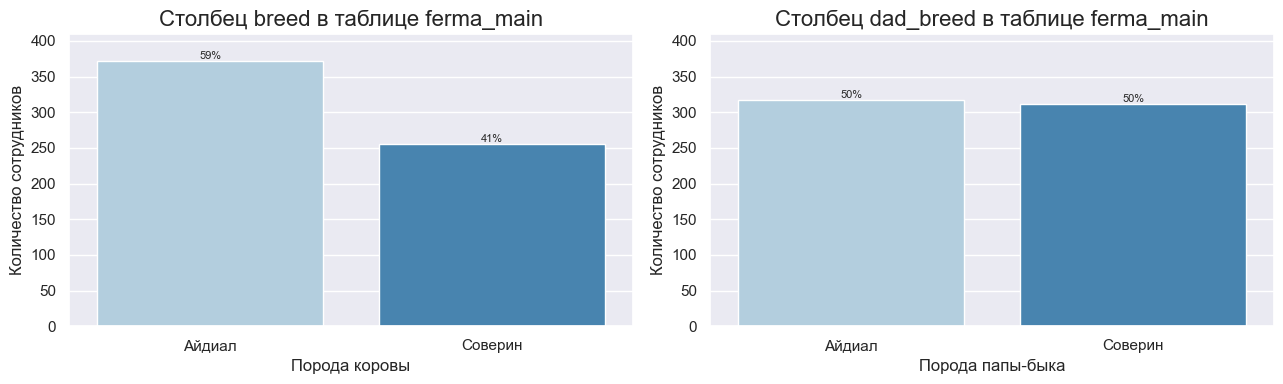

In [55]:
# построим пару столбчатых диаграмм для столбцов breed и dad_breed

compare_barplots(
    ferma_main, 'breed', 'Порода коровы', 'Столбец breed в таблице ferma_main',
    ferma_main, 'dad_breed', 'Порода папы-быка', 'Столбец dad_breed в таблице ferma_main'
)

Если папы-быки имеют породы Айдиал и Соверин почти поровну, то среди коров фермера порода Айдиал составляет бóльшую часть — 59% против породы Соверин, составляющей 41%. Возможно, коровы породы Айдиал более живучие и склонны к рождаемости

### `age`

In [56]:
# выведем на экран числовое распределение данных в столбце age

value_counts(ferma_main, 'age', 'ferma_main')

Распределение данных в столбце age таблицы ferma_main:
 
age
более_2_лет    518
менее_2_лет    110
Name: count, dtype: int64


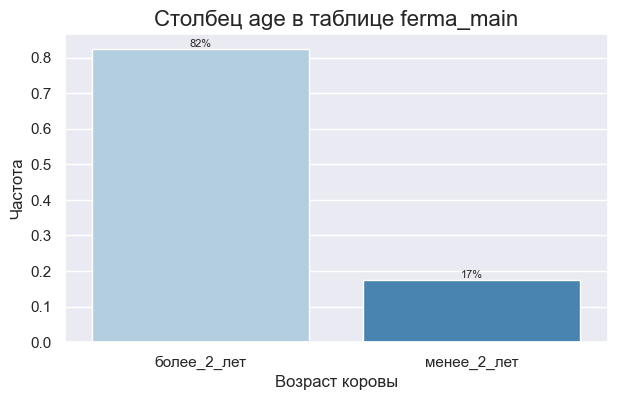

In [57]:
# выведем столбчатую диаграмму для столбца age в таблице ferma_main

barplot(ferma_main, 'age', 'Возраст коровы', 'Столбец age в таблице ferma_main')

Большинство или 82% коров в стаде фермера имеют возраст более двух лет

### `is_tasty`

In [58]:
# выведем на экран числовое распределение данных в столбце is_tasty

value_counts(ferma_main, 'is_tasty', 'ferma_main')

Распределение данных в столбце is_tasty таблицы ferma_main:
 
is_tasty
вкусно       370
не вкусно    258
Name: count, dtype: int64


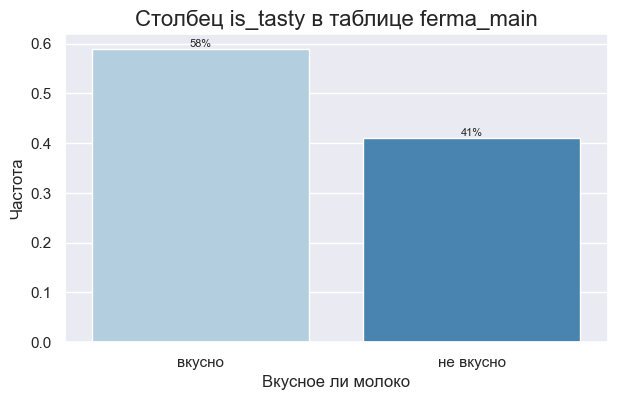

In [59]:
# выведем столбчатую диаграмму для столбца is_tasty в таблице ferma_main

barplot(ferma_main, 'is_tasty', 'Вкусное ли молоко', 'Столбец is_tasty в таблице ferma_main')

Видим, что больше половины коров в стаде фермера — 58% — дают вкусное молоко. Пока неизвестно, от чего зависит этот параметр

## Таблица `ferma_dad`

### `dad_name`

In [60]:
# выведем на экран числовое распределение данных в столбце dad_name

value_counts(ferma_dad, 'dad_name', 'ferma_dad')

Распределение данных в столбце dad_name таблицы ferma_dad:
 
dad_name
Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: count, dtype: int64


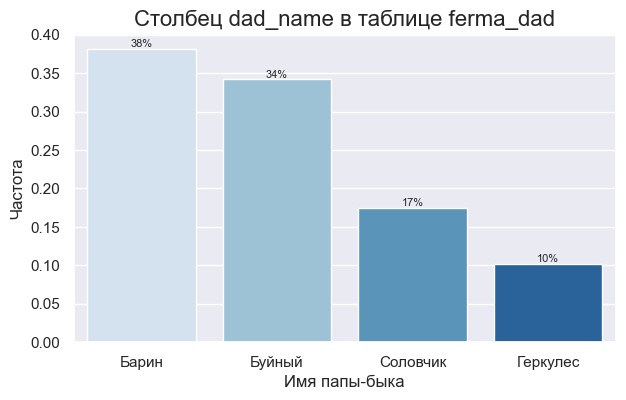

In [61]:
# выведем столбчатую диаграмму для столбца dad_name в таблице ferma_dad

barplot(ferma_dad, 'dad_name', 'Имя папы-быка', 'Столбец dad_name в таблице ferma_dad')

38% данных составляет бык по имени Барин, на втором месте — Буйный, на третьем и четвёртом — Соловчик и Геркулес соответственно

## Таблица `cow_buy`

Приступим к изучению коров, которых заказчик рассматривает для покупки

### `breed` и `dad_breed`

In [62]:
# выведем на экран числовое распределение данных в столбцах breed и dad_breed

value_counts(cow_buy, 'breed', 'cow_buy')
print(' ')
value_counts(cow_buy, 'dad_breed', 'cow_buy')

Распределение данных в столбце breed таблицы cow_buy:
 
breed
Айдиал     8
Соверин    8
Name: count, dtype: int64
 
Распределение данных в столбце dad_breed таблицы cow_buy:
 
dad_breed
Соверин    10
Айдиал      6
Name: count, dtype: int64


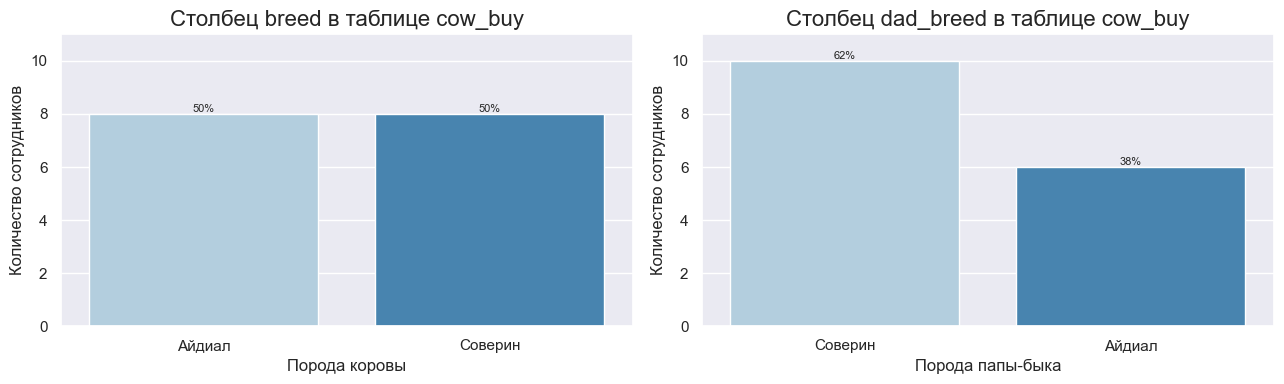

In [63]:
# построим пару столбчатых диаграмм для столбцов breed и dad_breed

compare_barplots(
    cow_buy, 'breed', 'Порода коровы', 'Столбец breed в таблице cow_buy',
    cow_buy, 'dad_breed', 'Порода папы-быка', 'Столбец dad_breed в таблице cow_buy'
)

Породы коров на покупку поровну делятся на Айдиал и Соверин, тогда как порода Соверин у пап-быков составляет 62% против породы Айдиал, составляющей 36%

### `dad_name`

In [64]:
# выведем на экран числовое распределение данных в столбце dad_name

value_counts(cow_buy, 'dad_name', 'cow_buy')

Распределение данных в столбце dad_name таблицы cow_buy:
 
dad_name
Буйный      7
Геркулес    5
Барин       2
Соловчик    2
Name: count, dtype: int64


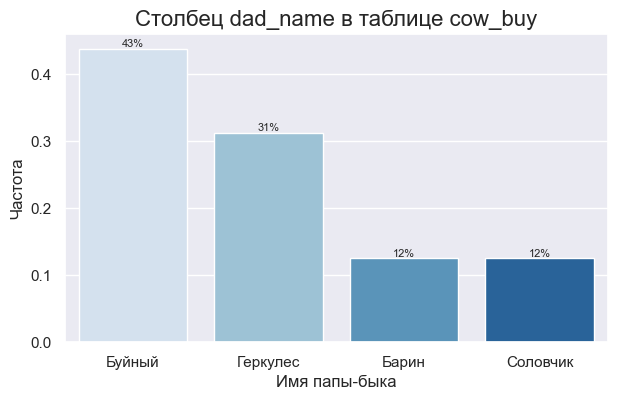

In [65]:
# выведем столбчатую диаграмму для столбца dad_name в таблице cow_buy

barplot(cow_buy, 'dad_name', 'Имя папы-быка', 'Столбец dad_name в таблице cow_buy')

Если среди коров фермера самым распространённым именем папы-быка являлся Барин, то в данных о коровах для покупки он лишь на третьем месте. Второе место занимает Геркулес — 43%, а первое — Буйный, составляя почти половину данных

### `pasture_type`

In [66]:
# выведем на экран числовое распределение данных в столбце pasture_type

value_counts(cow_buy, 'pasture_type', 'cow_buy')

Распределение данных в столбце pasture_type таблицы cow_buy:
 
pasture_type
Холмистое    8
Равнинное    8
Name: count, dtype: int64


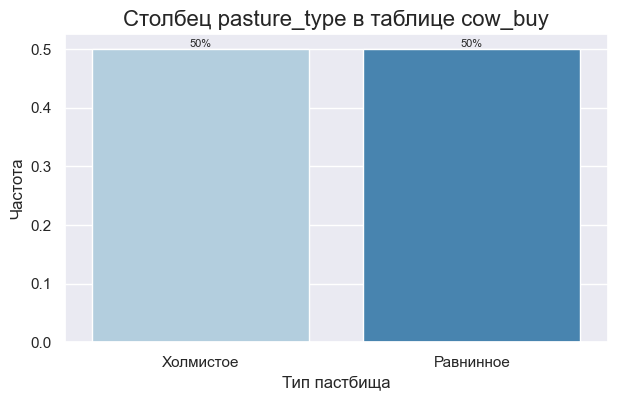

In [67]:
# выведем столбчатую диаграмму для столбца pasture_type в таблице cow_buy

barplot(cow_buy, 'pasture_type', 'Тип пастбища', 'Столбец pasture_type в таблице cow_buy')

Половина коровок на покупку паслась на холмистом пастбище, а другая половина — на равнинном

### `age`

In [68]:
# выведем на экран числовое распределение данных в столбце age

value_counts(cow_buy, 'age', 'cow_buy')

Распределение данных в столбце age таблицы cow_buy:
 
age
более_2_лет    11
менее_2_лет     5
Name: count, dtype: int64


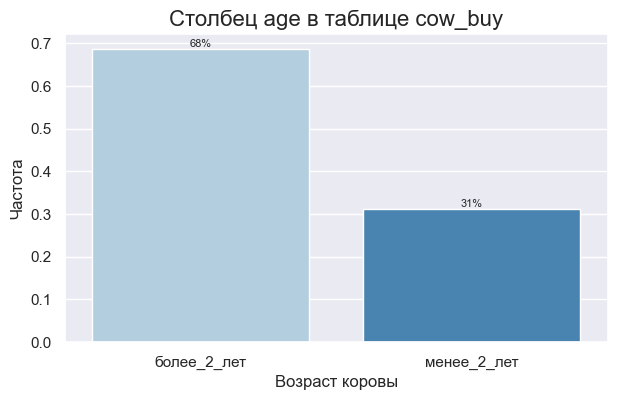

In [69]:
# выведем столбчатую диаграмму для столбца age в таблице cow_buy

barplot(cow_buy, 'age', 'Возраст коровы', 'Столбец age в таблице cow_buy')

Как и в стаде фермера, коровок, чей возраст составляет более 2 лет, гораздо больше

### `current_fat_percent`

In [70]:
# выведем на экран числовое распределение данных в столбце current_fat_percent

describe(cow_buy, 'current_fat_percent', 'cow_buy')

Числовое описание столбца current_fat_percent таблицы cow_buy:
 
count    16.000000
mean      3.571875
std       0.141620
min       3.340000
25%       3.415000
50%       3.585000
75%       3.692500
max       3.770000
Name: current_fat_percent, dtype: float64


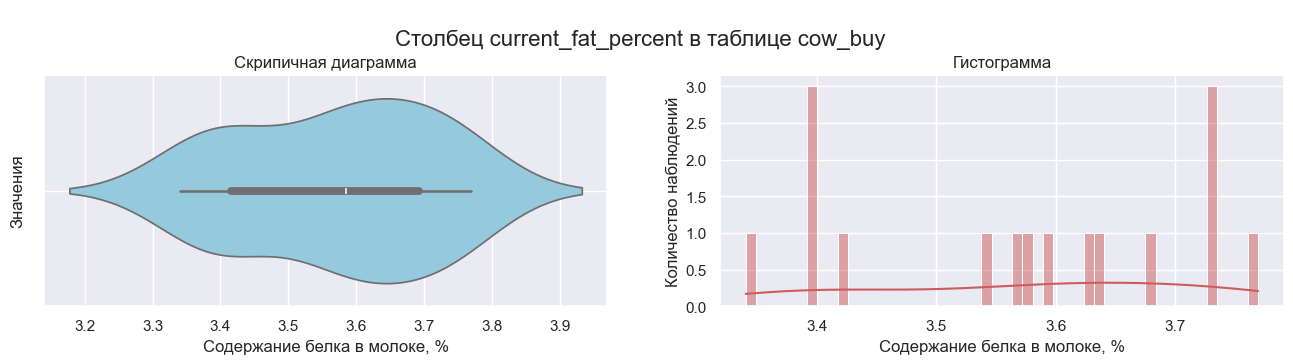

In [71]:
# построим гистограмму и скрипичную диаграмму для столбца current_fat_percent

hist_violin(cow_buy, 'current_fat_percent', 50, 'Столбец current_fat_percent в таблице cow_buy ', 'Содержание белка в молоке, %')

Видим, что и в стаде коров на покупку этот параметр также стандартизирован. В этих данных нет выбросов и аномальных значений, жирность молока коров «ЭкоФермы» колеблется от 3.34% до 3.77%. Больше всего в этих данных таких коров, которые дают молоко ровно 3.4% и 3.7% жирности. Обобщённо, коровы на покупку дают чуть менее жирное молоко, чем коровы в стаде фермера

### `current_protein_percent`

In [72]:
# выведем на экран числовое распределение данных в столбце current_protein_percent

describe(cow_buy, 'current_protein_percent', 'cow_buy')

Числовое описание столбца current_protein_percent таблицы cow_buy:
 
count    16.000000
mean      3.068250
std       0.011264
min       3.046000
25%       3.059500
50%       3.073500
75%       3.076750
max       3.081000
Name: current_protein_percent, dtype: float64


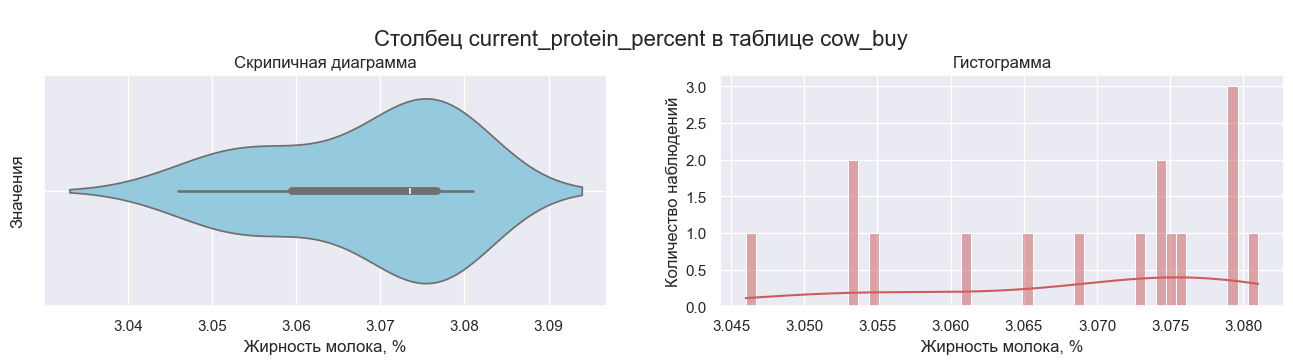

In [73]:
# построим гистограмму и скрипичную диаграмму для столбца current_protein_percent

hist_violin(cow_buy, 'current_protein_percent', 50, 'Столбец current_protein_percent в таблице cow_buy ', 'Жирность молока, %')

Содержание белка в молоке у коров на покупку незначительно меньше аналогичных показателей в стаде фермера. Если у фермера коровы, в среднем, дают молоко с 3.076% белка, то коровы на покупку дают молоко со средним показателем в 3.068% белка

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
    
Каждый из имеющихся признаков исследован более подробно. В данных нет выбросов и аномалий, они выглядят адекватно и реалистично
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Корреляционный анализ данных
</div>

---

In [74]:
def shapiro_test(data, col):
    
    """
    Функция shapiro_test проводит статистический тест Шапиро-Уилка для определения нормальности распредлений
    
    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : название столбца
    
    """
    
    statistic, p_value = shapiro(data[col])
    alpha = 0.05
    print(f'Результат теста Шапиро-Уилка для столбца {col}:')
    print(f'Статистика: {statistic}')
    print(f'p-value: {p_value}')
    if p_value > alpha:
        print('Не отвергаем нулевую гипотезу')
    else:
        print('Отвергаем нулевую гипотезу в пользу альтернативной')

In [75]:
def heatmap(data, target, num_cols, data_name):
    
    """
    Функция heatmap выводит на экран матрицу корреляции для датафрейма
    
    Аргументы:
    data (DataFrame) : датафрейм
    target (str) : название столбца с целевым признаком
    num_cols (list) : список названий столбцов с количественными признаками
    data_name (str) : название датафрейма
    
    """
    
    corr_matrix = data[[target] + num_cols].corr(method='spearman')
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
    plt.yticks(rotation=50)
    plt.title(f'Матрица корреляции для таблицы {data_name}')
    plt.show()

In [76]:
def scatter_plots(data, target, num_cols, data_name):
    
    """
    
    Функция scatter_plots строит диаграммы рассеяния для целевого признака и каждого из количественных столбцов
    
    Аргументы:
    data (DataFrame) : датафрейм
    target (str) : название столбца с целевым признаком
    num_cols (list) : список названий столбцов с количественными признаками
    data_name (str) : название датафрейма
    
    """
    
    num_plots = len(num_cols)
    nrows = (num_plots + 1) // 2
    plt.figure(figsize=(13, 10))
    
    colors = sns.color_palette('Blues', 1)
    
    for i, col in enumerate(num_cols):
        plt.subplot(nrows, 2, i + 1)
        sns.scatterplot(data=data, x=col, y=target, alpha=0.5, color=colors[0])
        correlation_coefficient = data[target].corr(data[col], method='spearman')
        plt.title(f'Диаграмма рассеяния для {target} и {col} (Коэф. корр.: {correlation_coefficient:.2f})')
        plt.xlabel(col)
        plt.ylabel(target)
    
    plt.tight_layout()
    plt.show()

---

Чтобы корректно обучить модель, сперва необходимо провести корреляционный анализ данных, изучить взаимосвязь между целевым признаком и входными. Для того, чтобы правильно выбрать коэффициент корреляции, нужно изучить распределение данных — провести статистический тест, который покажет, нормальное оно или нет. Для определения того, соответствует ли выборка нормальному распределению, используем тест Шапиро-Уилка. Демонстрационной выборкой будут являться столбцы с количественными признаками датафрейма `ferma_main` и столбец `milk_amount` с целевым признаком

Сформулируем нулевую и альтернативную гипотезы:

$$ 
H_0:\text{распределение данных является нормальным} 
$$

$$ 
H_1:\text{распределение данных не является нормальным} 
$$

Уровнем значимости установим стандартное значение в 0.05, так как в этом случае нам не нужна медицинская точность. Если p-значение будет ниже этого уровня значимости, то у нас будет достаточно доказательств, чтобы сказать, что данные выборки не получены из нормального распределения

In [77]:
# обозначим столбцы с количественными признаками

num_cols = ['eke', 'raw_protein', 'spo', 'fat_percent', 'protein_percent']

In [78]:
# проведём статистический тест для целевого признака

shapiro_test(ferma_main, 'milk_amount')

Результат теста Шапиро-Уилка для столбца milk_amount:
Статистика: 0.981349527835846
p-value: 3.540204147611803e-07
Отвергаем нулевую гипотезу в пользу альтернативной


In [79]:
# проведём тесты для количественных признаков

for col in num_cols:
    shapiro_test(ferma_main, col)
    print('')

Результат теста Шапиро-Уилка для столбца eke:
Статистика: 0.9713221788406372
p-value: 9.631184738623233e-10
Отвергаем нулевую гипотезу в пользу альтернативной

Результат теста Шапиро-Уилка для столбца raw_protein:
Статистика: 0.9437040686607361
p-value: 1.0713665740159917e-14
Отвергаем нулевую гипотезу в пользу альтернативной

Результат теста Шапиро-Уилка для столбца spo:
Статистика: 0.8555195331573486
p-value: 1.5345069056487493e-23
Отвергаем нулевую гипотезу в пользу альтернативной

Результат теста Шапиро-Уилка для столбца fat_percent:
Статистика: 0.7418986558914185
p-value: 4.189230905200583e-30
Отвергаем нулевую гипотезу в пользу альтернативной

Результат теста Шапиро-Уилка для столбца protein_percent:
Статистика: 0.9831666350364685
p-value: 1.2371704087854596e-06
Отвергаем нулевую гипотезу в пользу альтернативной



Нулевая гипотеза не подтвердилась ни для одного из признаков — ни один из них не имеет нормального распределения. Значит, для корреляционного анализа лучше использовать коэффициент корреляции Спирмана

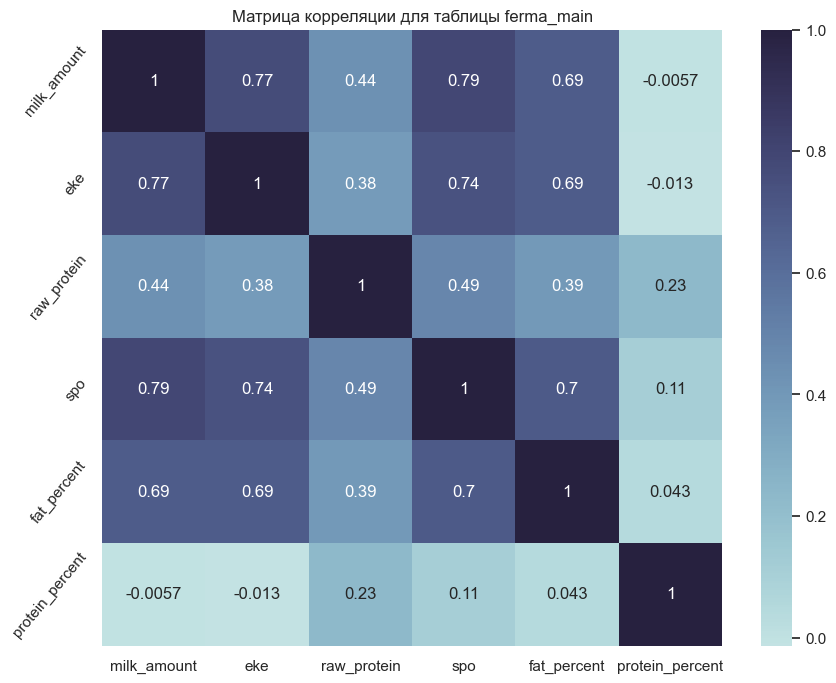

In [80]:
# выведем на экран матрицу корреляции

heatmap(ferma_main, TARGET, num_cols, 'ferma_main')

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
    
Сильнее всего целевой признак коррелирует с показателем питательности корма коровы (параметр ЭКЕ), с отношением сахара к протеину в корме коровы (параметр СПО) и с содержанием жиров в удое. Хотя мультиколлинеарности в данных не наблюдается, мы видим ощутимую взаимосвязь между признаками `eke`, `spo` и `fat_percent` 

</div>

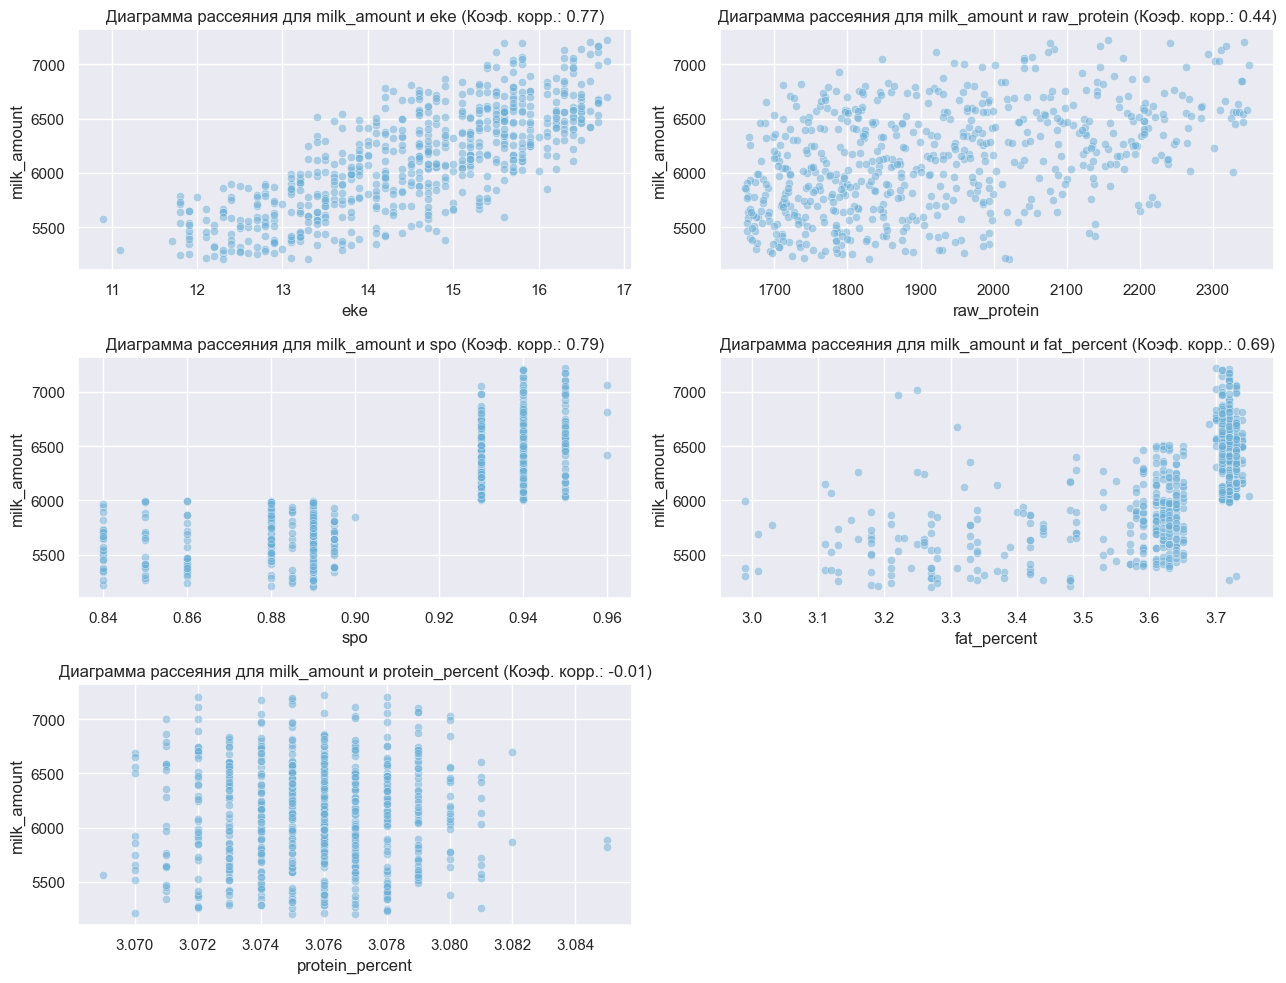

In [81]:
# построим диаграммы рассеяния

scatter_plots(ferma_main, TARGET, num_cols, 'ferma_main')

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
    
Сделаем выводы о взаимосвязи удоя с остальными признаками: <br>

- `protein_percent` Наблюдается незначительная отрицательная связь
- `fat_percent` На диаграмме рассеяния линейной зависимости не наблюдается, однако коэффициент корреляции говорит о заметной положительной связи между признаками
- `spo` Коэффициент корреляции высокий, но связь не является линейной
- `raw_protein` Наблюдаем умеренную линейную связь
- `eke` Заметная линейная зависимость

</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Обучение моделей линейной регресии
</div>

---

In [82]:
def split(data, target):
                                        
    """
    Функция split делит данные на тренировочную и тестовую выборки
    
    Аргументы:
    data (DataFrame) : датафрейм
    target (str) : целевой признак
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(
        data,
        target,
        random_state=RANDOM_STATE
    )
    
    return X_train, X_test, y_train, y_test

In [83]:
def train_test_size(X_train, X_test, y_train, y_test):
                                    
    """
    Функция train_test_size выводит на экран размерность разделённых на выборки данных
    
    Аргументы:
    X_train (DataFrame) : входные признаки тренировочной выборки
    X_test (DataFrame) : входные признаки тестовой выборки
    y_train (Series) : целевой признак тренировочной выборки
    y_test (Series) : целевой признак тестовой выборки
    
    """

    print('Тренировочная выборка')
    print(f'Размерность матрицы со входными признаками: {X_train.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_train.shape}')
    print(' ')
    print('Тестовая выборка')
    print(f'Размерность матрицы со входными признаками: {X_test.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_test.shape}')

In [84]:
def four_metrics(y_test, predictions):
    
    """
    Функция four_metrics рассчитывает и выводит на экран 4 метрики:
    MSE (среднеквадратичная ошибка), RMSE (корень из среднеквадратичной ошибки),
    MAE (средняя абсолютная ошибка), R2 (коэффициент детерминации)
    
    Аргументы:
    y_test (Series) : одномерный массив, содержащий целевой признак тестовой выборки
    predictions (Series/ndarray) : предсказанные значения целевого признака
    
    """
    
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    result = {
        'Метрика': ['MSE', 'RMSE', 'MAE', 'R2'],
        'Значение метрики на тестовой выборке': [mse, rmse, mae, r2]
    }
    
    result = pd.DataFrame(result)
    
    return mse, rmse, mae, r2, result

In [85]:
def residuals(y_test, predictions):
    
    """
    Функция residuals рассчитывает остатки модели,
    выводит на экран гистограмму распределения остатков и диаграмму рассеяния
    
    Аргументы:
    y_test (Series) : одномерный массив, содержащий целевой признак тестовой выборки
    predictions (Series/ndarray) : предсказанные значения целевого признака
    
    """
    
    residuals = y_test - predictions
    
    colors = sns.color_palette('Blues', 1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

    axes[0].hist(x=residuals, bins=30)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(x=predictions, y=residuals, alpha=0.5, color=colors)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии');

---

<div style="border: 1px solid rgba(28, 28, 28, 0.2); border-radius: 2px; background-color: rgba(255, 255, 255, 0.8); padding: 10px; font-size: 25px; color: rgba(28, 28, 28, 0.9);">
Линейная регрессия. Модель №1
</div>

Подготовим данные к обучению первой модели: сформируем тестовую и тренировочную выборки, запишем названия категориальных и количественных столбцов в отдельные переменные и проверим получившийся результат

In [86]:
# запишем названия категориальных и количественных признаков в переменные cat_col_names и num_col_names соответственно

cat_col_names = ['age', 'breed', 'pasture_type', 'dad_breed']
num_col_names = ['eke', 'raw_protein', 'spo']

In [87]:
# запишем названия признаков, которые не являются входными

columns_to_drop = ferma_main[['fat_percent', 'protein_percent', 'is_tasty', 'milk_amount', 'id']]

In [88]:
# обозначим входные и целевой признаки

X = ferma_main.drop(columns_to_drop, axis=1)
y = ferma_main['milk_amount']

In [89]:
# разделим данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = split(X, y) 

In [90]:
# проверим размерность получившихся выборок

train_test_size(X_train, X_test, y_train, y_test)

Тренировочная выборка
Размерность матрицы со входными признаками: (471, 7)
Размерность матрицы с целевым признаком: (471,)
 
Тестовая выборка
Размерность матрицы со входными признаками: (157, 7)
Размерность матрицы с целевым признаком: (157,)


Для преобразования категориальных признаков в числовые выберем метод кодирования `OneHotEncoding`, масштабирование числовых признаков произведём с помощью `StandardScaler`

In [91]:
# инициализируем метод кодирования

encoder = OneHotEncoder(drop='first', sparse=False)

In [92]:
# закодируем категориальные данные в тренировочной и тестовой выборках

X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

In [93]:
# получим из кодировщика список новых признаков

encoder_col_names = encoder.get_feature_names_out()

In [94]:
# проверим результат

print('Закодированная тренировочная выборка:')
print(' ')
print(X_train_ohe)
print(' ')
print(f'Обновлённый список признаков: {encoder_col_names}')

Закодированная тренировочная выборка:
 
[[0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]
 
Обновлённый список признаков: ['age_менее_2_лет' 'breed_Соверин' 'pasture_type_Холмистое'
 'dad_breed_Соверин']


In [95]:
# инициализируем метод масштабирования

scaler = StandardScaler()

In [96]:
# масштабируем количественные данные в тренировочной и тестовой выборках

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [97]:
# превратим получившиеся матрицы в датафреймы

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

In [98]:
# объединим категориальные и количественные данные в тренировочной и тестовой выборках

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

---

In [99]:
# инициализируем модель линейной регрессии

model_lr = LinearRegression()

In [100]:
# обучим модель на тренировочных данных

model_lr.fit(X_train, y_train)

LinearRegression()

In [101]:
# получим предсказания модели на тестовых данных

predictions = model_lr.predict(X_test)

In [102]:
# рассчитаем метрики для первой модели и выведем результат на экран

mse, rmse, mae, r2, result = four_metrics(y_test, predictions)
result

,Метрика,Значение метрики на тестовой выборке
0,MSE,43887.015010
1,RMSE,209.492279
2,MAE,164.241945
3,R2,0.784408


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Построена и обучена линейная модель для предсказания удоя бурёнок. Для этой модели были рассчитаны 4 метрики
    
MSE или среднеквадратичная ошибка показывает, на какое значение в среднем предсказание отличается от истинного значения. Измеряется в квадратных единицах целевого признака, то есть, в квадратных киллограммах, из-за чего метрику сложно интерпритировать. Полученная модель ошибается в среднем на 43887 килограмм²

Метрика RMSE или корень среднеквадратичной ошибки показывает, на какое значение в среднем предсказание отличается от истинного значения, результат же измеряется в единицах целевого признака. Таким образом, полученная модель ошибается в среднем на 209 кг молока. При медиане целевого признака в 6133 кг — неплохой результат, но и не идеальный

Средняя абсолютная ошибка или MAE также, как и RMSE, показывает, на какое значение в среднем предсказание отличается от истинного значения. При этом она более робастная, то есть, нечувствительная к выбросам. В этом случае она показывает, что модель в среднем ошибается на 164 кг молока

Обратим внимание на метрику R2 или коэффициент детерминации. Он показывает, в скольких процентах случаев предсказание модели точнее, чем среднее значение целевого признака. В данном случае результат расчёта метрики говорит о том, что полученная модель даёт предсказания более точные, чем среднее значение целевого признака в 78.44% случаев. И этот результат тоже нельзя назвать идеальным
    
</div>

Приступим к анализу остатков: рассчитаем их, а затем построим гистограмму их распределения и диаграмму рассеяния

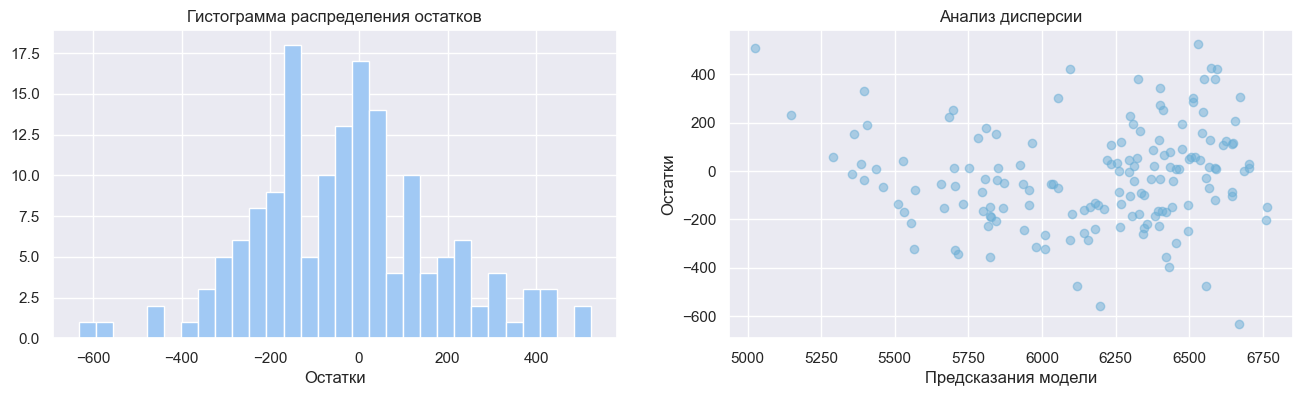

In [103]:
# проведём анализ остатков

residuals(y_test, predictions)

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Гистограмма распределения остатков показывает скошенность влево на -200 единиц, и это значит, что модель часто даёт завышенные предсказания, её прогнозы несколько больше истинных значений. При этом распределение нельзя назвать мультимодальным, потому что в нём нет выбросов. Диаграмма рассеяния показывает небольшое непостоянство остатков — модель ошибается неравномерно при высоких значениях
    
</div>

<div style="border: 1px solid rgba(28, 28, 28, 0.2); border-radius: 2px; background-color: rgba(255, 255, 255, 0.8); padding: 10px; font-size: 25px; color: rgba(28, 28, 28, 0.9);">
Линейная регрессия. Модель №2
</div>

Графики показывают, что параметр СПО и целевой признак имеют нелинейную зависимость. На этапе исследовательского анализа данных для параметра СПО была построена гистограмма. Она показывает, как данные разделяются на две категории. Чтобы исключить нелинейность, трансформируем этот параметр из числового в категориальный, используя увиденную на графике границу нелинейности — создадим новый столбец, в котором каждому значению выше 0.91 будет соответствовать значение 1, ниже — значение 0

Параметр ЭКЕ также нелинейно связан с целевым признаком. На диаграмме рассеяния параметра ЭКЕ наблюдалась парабола, поэтому возведём значения столбца в квадрат — исключим нелинейность

In [104]:
# запишем выявленную границу нелинейности в переменную nonlinear_threshold

nonlinear_threshold = 0.91 

In [105]:
# переведём признак СПО из числового в категориальный, результат запишем в столбец spo_cat

ferma_main['spo_cat'] = (ferma_main['spo'].apply(lambda x: '0' if x <= nonlinear_threshold else '1'))

In [106]:
# возведём значения признака ЭКЕ в квадрат, результат запишем в столбец eke_squared

ferma_main['eke_squared'] = ferma_main['eke'] ** 2

In [107]:
# проверим результат

get_info(ferma_main)

Пять случайных строк таблицы:


,id,milk_amount,eke,raw_protein,spo,breed,pasture_type,dad_breed,fat_percent,protein_percent,is_tasty,age,spo_cat,eke_squared
345,346,6290,15.5,1817,0.940,Соверин,Холмистое,Соверин,3.71,3.073,вкусно,более_2_лет,1,240.25
54,55,5383,13.6,1955,0.895,Соверин,Холмистое,Айдиал,3.53,3.080,не вкусно,менее_2_лет,0,184.96
150,151,6221,14.7,2156,0.930,Айдиал,Равнинное,Соверин,3.72,3.074,не вкусно,более_2_лет,1,216.09
578,579,5235,12.2,1724,0.860,Соверин,Холмистое,Соверин,3.28,3.078,не вкусно,менее_2_лет,0,148.84
598,599,6584,16.4,2309,0.940,Соверин,Холмистое,Соверин,3.72,3.076,вкусно,более_2_лет,1,268.96


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               628 non-null    int64  
 1   milk_amount      628 non-null    int64  
 2   eke              628 non-null    float64
 3   raw_protein      628 non-null    int64  
 4   spo              628 non-null    float64
 5   breed            628 non-null    object 
 6   pasture_type     628 non-null    object 
 7   dad_breed        628 non-null    object 
 8   fat_percent      628 non-null    float64
 9   protein_percent  628 non-null    float64
 10  is_tasty         628 non-null    object 
 11  age              628 non-null    object 
 12  spo_cat          628 non-null    object 
 13  eke_squared      628 non-null    float64
dtypes: float64(5), int64(3), object(6)
memory usage: 73.6+ KB
None


In [108]:
# запишем названия категориальных и количественных признаков в переменные cat_col_names_2 и num_col_names_2

cat_col_names_2 = ['age', 'breed', 'pasture_type', 'dad_breed', 'spo_cat']
num_col_names_2 = ['eke_squared', 'raw_protein']

In [109]:
# запишем названия признаков, которые не являются входными

columns_to_drop_2 = ferma_main[['fat_percent', 'protein_percent', 'is_tasty', 'milk_amount', 'id', 'spo', 'eke']]

In [110]:
# обозначим входные и целевой признаки

X_2 = ferma_main.drop(columns_to_drop_2, axis=1)
y_2 = ferma_main['milk_amount']

In [111]:
# разделим данные на тренировочную и тестовую выборки

X_train_2, X_test_2, y_train_2, y_test_2 = split(X_2, y_2) 

In [112]:
# проверим размерность получившихся выборок

train_test_size(X_train_2, X_test_2, y_train_2, y_test_2)

Тренировочная выборка
Размерность матрицы со входными признаками: (471, 7)
Размерность матрицы с целевым признаком: (471,)
 
Тестовая выборка
Размерность матрицы со входными признаками: (157, 7)
Размерность матрицы с целевым признаком: (157,)


In [113]:
# инициализируем метод кодирования

encoder_2 = OneHotEncoder(drop='first', sparse=False)

In [114]:
# обучим кодировщик и закодируем категориальные данные в тренировочной и тестовой выборках

X_train_ohe_2 = encoder_2.fit_transform(X_train_2[cat_col_names_2])
X_test_ohe_2 = encoder_2.transform(X_test_2[cat_col_names_2])

In [115]:
# получим из кодировщика список новых признаков

encoder_col_names_2 = encoder_2.get_feature_names_out()

In [116]:
# проверим результат

print('Закодированная тренировочная выборка:')
print(' ')
print(X_train_ohe_2)
print(' ')
print(f'Обновлённый список признаков: {encoder_col_names_2}')

Закодированная тренировочная выборка:
 
[[0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
 
Обновлённый список признаков: ['age_менее_2_лет' 'breed_Соверин' 'pasture_type_Холмистое'
 'dad_breed_Соверин' 'spo_cat_1']


In [117]:
# инициализируем метод масштабирования

scaler_2 = StandardScaler()

In [118]:
# масштабируем количественные данные в тренировочной и тестовой выборках

X_train_scaled_2 = scaler_2.fit_transform(X_train_2[num_col_names_2])
X_test_scaled_2 = scaler_2.transform(X_test_2[num_col_names_2])

In [119]:
# превратим получившиеся матрицы в датафреймы

X_train_ohe_2 = pd.DataFrame(X_train_ohe_2, columns=encoder_col_names_2)
X_test_ohe_2 = pd.DataFrame(X_test_ohe_2, columns=encoder_col_names_2)
X_train_scaled_2 = pd.DataFrame(X_train_scaled_2, columns=num_col_names_2)
X_test_scaled_2 = pd.DataFrame(X_test_scaled_2, columns=num_col_names_2)

In [120]:
# объединим категориальные и количественные данные в тренировочном и тестовом датафреймах

X_train_2 = pd.concat([X_train_ohe_2, X_train_scaled_2], axis=1)
X_test_2 = pd.concat([X_test_ohe_2, X_test_scaled_2], axis=1)

---

In [121]:
# инициализируем модель линейной регрессии

model_lr_2 = LinearRegression()

In [122]:
# обучим модель на тренировочных данных

model_lr_2.fit(X_train_2, y_train_2)

LinearRegression()

In [123]:
# получим предсказания модели на тестовых данных

predictions_2 = model_lr_2.predict(X_test_2)

In [124]:
# рассчитаем метрики для второй модели и выведем результат на экран

mse_2, rmse_2, mae_2, r2_2, result_2 = four_metrics(y_test_2, predictions_2)
result_2

,Метрика,Значение метрики на тестовой выборке
0,MSE,37030.911311
1,RMSE,192.434174
2,MAE,149.039652
3,R2,0.818088


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

По сравнению с предыдущей моделью, удалось улучшить точность с 78.44% до 81.8%. Этот показатель отображается в метрике R2. Снижение MSE, RMSE и MAE также говорит об улучшении точности модели
    
</div>

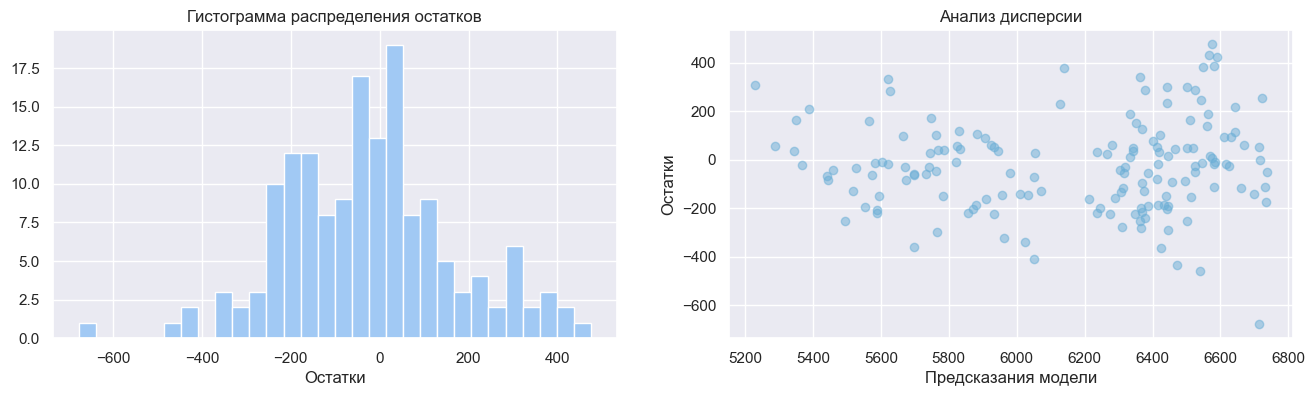

In [125]:
# проведём анализ остатков

residuals(y_test_2, predictions_2)

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Видны улучшения и на графиках: гистограмма распределения остатков стала более равномерной, как и ошибки на диаграмме рассеяния
    
</div>

<div style="border: 1px solid rgba(28, 28, 28, 0.2); border-radius: 2px; background-color: rgba(255, 255, 255, 0.8); padding: 10px; font-size: 25px; color: rgba(28, 28, 28, 0.9);">
Линейная регрессия. Модель №3
</div>

Построим ещё одну модель линейной регрессии с учётом нового признака из датафрейма `ferma_dad`. Учтём при этом преобразование нелинейности во второй модели

In [126]:
# соединим датафреймы ferma_main и ferma_dad

ferma_main_new = ferma_main.merge(ferma_dad, on='id', how='inner')

In [127]:
# проверим результат

get_info(ferma_main_new)

Пять случайных строк таблицы:


,id,milk_amount,eke,raw_protein,spo,breed,pasture_type,dad_breed,fat_percent,protein_percent,is_tasty,age,spo_cat,eke_squared,dad_name
16,18,5777,12.4,1873,0.895,Айдиал,Холмистое,Айдиал,3.03,3.080,вкусно,более_2_лет,0,153.76,Буйный
272,274,5204,12.3,2021,0.890,Соверин,Холмистое,Соверин,3.27,3.075,вкусно,менее_2_лет,0,151.29,Барин
233,235,7067,15.8,2053,0.940,Айдиал,Холмистое,Айдиал,3.73,3.079,вкусно,более_2_лет,1,249.64,Буйный
212,214,6081,13.6,1816,0.930,Айдиал,Равнинное,Соверин,3.72,3.074,не вкусно,более_2_лет,1,184.96,Барин
406,408,5392,11.9,1827,0.890,Айдиал,Равнинное,Соверин,3.59,3.078,вкусно,менее_2_лет,0,141.61,Соловчик


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               628 non-null    int64  
 1   milk_amount      628 non-null    int64  
 2   eke              628 non-null    float64
 3   raw_protein      628 non-null    int64  
 4   spo              628 non-null    float64
 5   breed            628 non-null    object 
 6   pasture_type     628 non-null    object 
 7   dad_breed        628 non-null    object 
 8   fat_percent      628 non-null    float64
 9   protein_percent  628 non-null    float64
 10  is_tasty         628 non-null    object 
 11  age              628 non-null    object 
 12  spo_cat          628 non-null    object 
 13  eke_squared      628 non-null    float64
 14  dad_name         628 non-null    object 
dtypes: float64(5), int64(3), object(7)
memory usage: 73.7+ KB
None


In [128]:
# применим функцию preprocess

preprocess(ferma_main_new, 'ferma_main_new')

В таблице ferma_main_new не найдено ни одного пропуска!
В таблице ferma_main_new не найдено ни одного дубликата!


In [129]:
# запишем названия категориальных и количественных признаков в переменные cat_col_names и num_col_names

cat_col_names_3 = ['age', 'breed', 'pasture_type', 'dad_breed', 'spo_cat', 'dad_name']
num_col_names_3 = ['eke_squared', 'raw_protein']

In [130]:
# запишем названия признаков, которые не являются входными

columns_to_drop_3 = ['fat_percent', 'protein_percent', 'is_tasty', 'milk_amount', 'id', 'spo']

In [131]:
# обозначим входные и целевой признаки

X_3 = ferma_main_new.drop(columns_to_drop_3, axis=1)
y_3 = ferma_main_new['milk_amount']

In [132]:
# разделим данные на тренировочную и тестовую выборки

X_train_3, X_test_3, y_train_3, y_test_3 = split(X_3, y_3) 

In [133]:
# проверим размерность получившихся выборок

train_test_size(X_train_3, X_test_3, y_train_3, y_test_3)

Тренировочная выборка
Размерность матрицы со входными признаками: (471, 9)
Размерность матрицы с целевым признаком: (471,)
 
Тестовая выборка
Размерность матрицы со входными признаками: (157, 9)
Размерность матрицы с целевым признаком: (157,)


In [134]:
# инициализируем метод кодирования

encoder_3 = OneHotEncoder(drop='first', sparse=False)

In [135]:
# обучим кодировщик и закодируем категориальные данные в тренировочной и тестовой выборках

X_train_ohe_3 = encoder_3.fit_transform(X_train_3[cat_col_names_3])
X_test_ohe_3 = encoder_3.transform(X_test_3[cat_col_names_3])

In [136]:
# получим из кодировщика список новых признаков

encoder_col_names_3 = encoder_3.get_feature_names_out()

In [137]:
# проверим результат

print('Закодированная тренировочная выборка:')
print(' ')
print(X_train_ohe_3)
print(' ')
print(f'Обновлённый список признаков: {encoder_col_names_3}')

Закодированная тренировочная выборка:
 
[[0. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]]
 
Обновлённый список признаков: ['age_менее_2_лет' 'breed_Соверин' 'pasture_type_Холмистое'
 'dad_breed_Соверин' 'spo_cat_1' 'dad_name_Буйный' 'dad_name_Геркулес'
 'dad_name_Соловчик']


In [138]:
# инициализируем метод масштабирования

scaler_3 = StandardScaler()

In [139]:
# масштабируем количественные данные в тренировочной и тестовой выборках

X_train_scaled_3 = scaler_3.fit_transform(X_train_3[num_col_names_3])
X_test_scaled_3 = scaler_3.transform(X_test_3[num_col_names_3])

In [140]:
# превратим получившиеся матрицы в датафреймы

X_train_ohe_3 = pd.DataFrame(X_train_ohe_3, columns=encoder_col_names_3)
X_test_ohe_3 = pd.DataFrame(X_test_ohe_3, columns=encoder_col_names_3)
X_train_scaled_3 = pd.DataFrame(X_train_scaled_3, columns=num_col_names_3)
X_test_scaled_3 = pd.DataFrame(X_test_scaled_3, columns=num_col_names_3)

In [141]:
# объединим категориальные и количественные данные в тренировочном и тестовом датафреймах

X_train_3 = pd.concat([X_train_ohe_3, X_train_scaled_3], axis=1)
X_test_3 = pd.concat([X_test_ohe_3, X_test_scaled_3], axis=1)

---

In [142]:
# инициализируем модель линейной регрессии

model_lr_3 = LinearRegression()

In [143]:
# обучим модель на тренировочных данных

model_lr_3.fit(X_train_3, y_train_3)

LinearRegression()

In [144]:
# получим предсказания модели на тестовых данных

predictions_3 = model_lr_3.predict(X_test_3)

In [145]:
# рассчитаем метрики для третьй модели и выведем результат на экран

mse_3, rmse_3, mae_3, r2_3, result_3 = four_metrics(y_test_3, predictions_3)
result_3

,Метрика,Значение метрики на тестовой выборке
0,MSE,35673.889886
1,RMSE,188.875329
2,MAE,146.163024
3,R2,0.824754


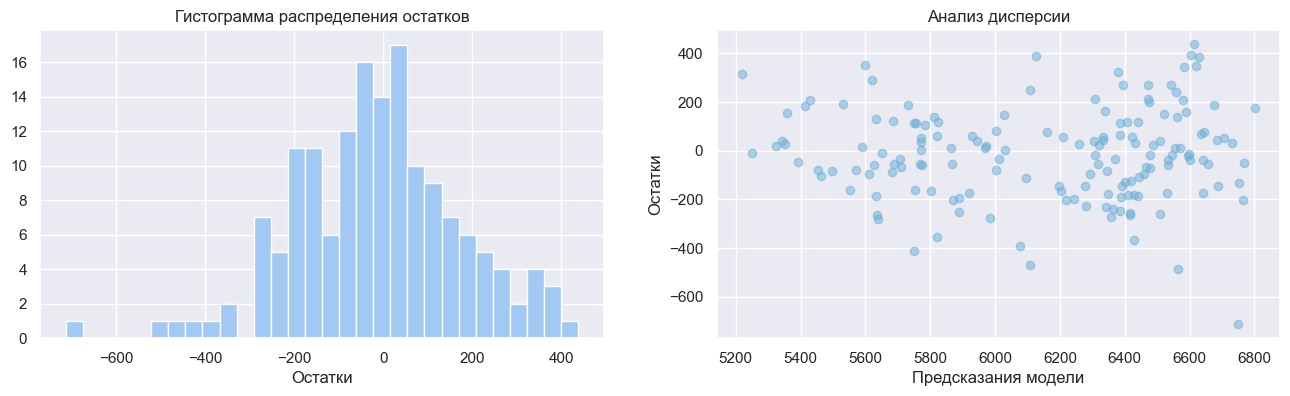

In [146]:
# проведём анализ остатков

residuals(y_test_3, predictions_3)

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Анализ остатков показывает, что распределение стало более равномерным. В метриках также заметно улучшение
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Сравнение моделей линейной регреcсии
</div>

---

In [147]:
# выведем на экран результаты обучения первой модели

print('Метрики первой модели на тестовой выборке:')
result

Метрики первой модели на тестовой выборке:


,Метрика,Значение метрики на тестовой выборке
0,MSE,43887.015010
1,RMSE,209.492279
2,MAE,164.241945
3,R2,0.784408


In [148]:
# выведем на экран результаты обучения второй модели

print('Метрики второй модели на тестовой выборке:')
result_2

Метрики второй модели на тестовой выборке:


,Метрика,Значение метрики на тестовой выборке
0,MSE,37030.911311
1,RMSE,192.434174
2,MAE,149.039652
3,R2,0.818088


In [149]:
# выведем на экран результаты обучения третьей модели

print('Метрики третьй модели на тестовой выборке:')
result_3

Метрики третьй модели на тестовой выборке:


,Метрика,Значение метрики на тестовой выборке
0,MSE,35673.889886
1,RMSE,188.875329
2,MAE,146.163024
3,R2,0.824754


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Чем ближе значение таких метрик, как MSE, RMSE и MAE к нулю, тем точнее работает модель. Согласно выведенным выше метрикам, лучше всего работает третья модель, в которой были учтены нелинейность признаков и новый признак из датафрейма `ferma_dad`. Это подтверждает и анализ остатков — в третьей модели гистограмма распределения остатков показывает самый равномерный результат, как и диаграмма рассеяния
    
</div>

In [150]:
# определим доверительный интервал

print('95% доверительный интервал:', st.norm.interval(confidence=0.95, loc=np.mean(predictions_3), scale=st.sem(predictions_3)))

95% доверительный интервал: (6092.340075854288, 6221.3750700583805)


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

95% доверительный интервал находится в промежутке между 6092 кг и 6221 кг. Это значит, что модель, в среднем, ошибается на 129 кг. Этот результат является хорошим с учётом размеров данных
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Применение лучшей модели линейной регресии
</div>

---

В таблице `cow_buy`, предоставленной компанией, продающей коров, отсутствуют параметры `spo`, `eke` и `raw_protein`. Недавно технологи заказчика пересмотрели параметры корма и планируют внедрить их после расширения стада. При применении предсказательной модели к этим бурёнкам необходимо использовать новые параметры — по новой схеме фермер планирует увеличить средние значения этих параметров на 5%. Так как у нас нет возможности уточнить у заказчика, на основе чего именно рассчитываются значения `spo`, `eke` и `raw_protein`, логично предположим, что эти параметры рассчитываются на основе породы бурёнки и типа пастбища, на котором она пасётся. Чтобы добавить в таблицу увеличенные на 5% средние значения этих параметров, необходимо рассчитать текущие средние значения и умножить их на 1.05

In [151]:
# добавим в cow_buy средние параметры spo, eke и raw_protein из таблицы фермера и увеличим их на 5 процентов

mean_values = ferma_main_new[['spo', 'eke', 'raw_protein']].mean() * 1.05
cow_buy.loc[:, ['mean_spo', 'mean_eke', 'mean_raw_protein']] = mean_values.values

In [152]:
# проверим результат

get_info(cow_buy)

Пять случайных строк таблицы:


,breed,pasture_type,dad_breed,dad_name,current_fat_percent,current_protein_percent,age,mean_spo,mean_eke,mean_raw_protein
0,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.958744,15.276162,2019.947532
15,Соверин,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,0.958744,15.276162,2019.947532
7,Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,0.958744,15.276162,2019.947532
18,Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,более_2_лет,0.958744,15.276162,2019.947532
11,Соверин,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.958744,15.276162,2019.947532


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 0 to 18
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   breed                    16 non-null     object 
 1   pasture_type             16 non-null     object 
 2   dad_breed                16 non-null     object 
 3   dad_name                 16 non-null     object 
 4   current_fat_percent      16 non-null     float64
 5   current_protein_percent  16 non-null     float64
 6   age                      16 non-null     object 
 7   mean_spo                 16 non-null     float64
 8   mean_eke                 16 non-null     float64
 9   mean_raw_protein         16 non-null     float64
dtypes: float64(5), object(5)
memory usage: 1.4+ KB
None


In [153]:
# применим функцию preprocess

preprocess(cow_buy, 'cow_buy')

В таблице cow_buy не найдено ни одного пропуска!
В таблице cow_buy не найдено ни одного дубликата!


In [154]:
# создадим копию таблицы

cow_buy_copy = cow_buy.copy()

Значения увеличились корректно, можно продолжать работу с таблицей — нормализуем данные перед прогнозом, применив OneHotEncoding и StandardScaler к тем же признакам, которые были нормализованы в таблице `ferma_main`

In [155]:
# переведём признак СПО из числового в категориальный, результат запишем в столбец mean_spo_cat

cow_buy.loc[:, 'mean_spo_cat'] = cow_buy['mean_spo'].apply(lambda x: '0' if x <= nonlinear_threshold else '1')

In [156]:
# возведём значения признака ЭКЕ в квадрат, результат запишем в столбец mean_eke_squared

cow_buy.loc[:, 'mean_eke_squared'] = cow_buy['mean_eke'] ** 2

In [157]:
# запишем названия категориальных и количественных признаков в переменные cat_col_names_4 и num_col_names_4

cat_col_names_4 = ['age', 'breed', 'pasture_type', 'dad_breed', 'mean_spo_cat', 'dad_name']
num_col_names_4 = ['mean_eke_squared', 'mean_raw_protein']

In [158]:
# запишем названия признаков, которые не являются входными

columns_to_drop_4 = ['current_fat_percent', 'current_protein_percent', 'is_tasty', 'milk_amount', 'id', 'spo']

In [159]:
# преобразуем категориальные признаки в числовые с помощью кодирования OneHotEncoding

cow_buy_ohe = encoder_3.transform(cow_buy[cat_col_names_4])

In [160]:
# получим из кодировщика список новых признаков

encoder_col_names_4 = encoder_3.get_feature_names_out()

In [161]:
# масштабируем числовые признаки с помощью StandardScaler

cow_buy_scaled = scaler_3.fit_transform(cow_buy[num_col_names_4])

In [162]:
# превратим получившиеся матрицы в датафреймы

cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names_4)
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names_4)

In [163]:
# объединим категориальные и количественные данные

cow_buy = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)

In [164]:
# получим предсказания модели и сохраним результат в переменную predictions_4

predictions_4 = model_lr_3.predict(cow_buy)   

In [165]:
# создадим столбец с предсказанными значениями

cow_buy_copy['milk_amount_predicted'] = predictions_4

In [166]:
# оценим результат

cow_buy_copy.head()

,breed,pasture_type,dad_breed,dad_name,current_fat_percent,current_protein_percent,age,mean_spo,mean_eke,mean_raw_protein,milk_amount_predicted
0,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.958744,15.276162,2019.947532,6494.942591
1,Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.958744,15.276162,2019.947532,6263.734322
2,Соверин,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.958744,15.276162,2019.947532,6169.023069
3,Соверин,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.958744,15.276162,2019.947532,6478.112671
4,Соверин,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.958744,15.276162,2019.947532,6427.169360


Теперь взглянем на тех коров, чей удой выше 6000 килограмм

In [167]:
# посмотрим на срез данных

cow_buy_copy[(cow_buy_copy['milk_amount_predicted'] >= 6000)]

,breed,pasture_type,dad_breed,dad_name,current_fat_percent,current_protein_percent,age,mean_spo,mean_eke,mean_raw_protein,milk_amount_predicted
0,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.958744,15.276162,2019.947532,6494.942591
1,Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.958744,15.276162,2019.947532,6263.734322
2,Соверин,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.958744,15.276162,2019.947532,6169.023069
3,Соверин,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.958744,15.276162,2019.947532,6478.112671
4,Соверин,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.958744,15.276162,2019.947532,6427.169360
5,Соверин,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,0.958744,15.276162,2019.947532,6310.403512
7,Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,0.958744,15.276162,2019.947532,6456.283031
9,Соверин,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.958744,15.276162,2019.947532,6285.563962
10,Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,0.958744,15.276162,2019.947532,6229.731154
11,Соверин,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.958744,15.276162,2019.947532,6502.952220


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Обучение модели линейной регрессии завершено. Всего построено три различающиеся модели, из которых самой точной оказалась третья. Выполнен расчёт целевого признака на основе этой модели
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Обучение модели логистической регресии
</div>

---

Построим модель логистической регрессии на данных датасета `ferma_main`. В качестве целевого признака здесь будет использован параметр `is_tasty`, то есть, модель будет предсказывать вкус молока; в качестве входных используем те же самые признаки, что и для построения модели линейной регрессии — возраст, породу, тип пастбища, породу папы быка, ЭКЕ, СПО и содержание сырого протеина; добавим к ним ещё два — жирность молока и содержание в нём белка, так как эти признаки, согласно логике, напрямую влияют на вкус продукта. В возведении в квадрат признака ЭКЕ и переведении признака СПО в категориальный в этом случае нет необходимости, потому что при построении модели линейной регрессии мы использовали это для устранения нелинейной зависимости

In [168]:
# создадим столбец is_tasty_cat, в котором вкусу или его отсутствию будет соответствовать цифра 1 или 0 

ferma_main_new['is_tasty_cat'] = ferma_main_new['is_tasty'].replace('вкусно', 1)
ferma_main_new['is_tasty_cat'] = ferma_main_new['is_tasty_cat'].replace('не вкусно', 0)

In [169]:
# проверим результат

value_counts(ferma_main_new, 'is_tasty_cat', 'ferma_main_new')

Распределение данных в столбце is_tasty_cat таблицы ferma_main_new:
 
is_tasty_cat
1    370
0    258
Name: count, dtype: int64


In [170]:
# запишем названия категориальных и количественных признаков в переменные cat_col_names_5 и num_col_names_5

cat_col_names_5 = ['age', 'breed', 'pasture_type', 'dad_breed', 'dad_name']
num_col_names_5 = ['eke', 'raw_protein', 'fat_percent', 'protein_percent', 'spo']

In [171]:
# запишем названия признаков, которые не являются входными

columns_to_drop_5 = ferma_main_new[['is_tasty', 'id', 'milk_amount', 'is_tasty_cat', 'spo_cat', 'eke_squared']]

In [172]:
# обозначим входные и целевой признаки

X_5 = ferma_main_new.drop(columns_to_drop_5, axis=1)
y_5 = ferma_main_new['is_tasty_cat']

In [173]:
# разделим данные на тренировочную и тестовую выборки

X_train_5, X_test_5, y_train_5, y_test_5 = split(X_5, y_5) 

In [174]:
# проверим размерность получившихся выборок

train_test_size(X_train_5, X_test_5, y_train_5, y_test_5)

Тренировочная выборка
Размерность матрицы со входными признаками: (471, 10)
Размерность матрицы с целевым признаком: (471,)
 
Тестовая выборка
Размерность матрицы со входными признаками: (157, 10)
Размерность матрицы с целевым признаком: (157,)


In [175]:
# инициализируем метод кодирования

encoder_5 = OneHotEncoder(drop='first', sparse=False)

In [176]:
# обучим кодировщик и закодируем категориальные данные в тренировочной и тестовой выборках

X_train_ohe_5 = encoder_5.fit_transform(X_train_5[cat_col_names_5])
X_test_ohe_5 = encoder_5.transform(X_test_5[cat_col_names_5])

In [177]:
# получим из кодировщика список новых признаков

encoder_col_names_5 = encoder_5.get_feature_names_out()

In [178]:
# проверим результат

print('Закодированная тренировочная выборка:')
print(' ')
print(X_train_ohe_5)
print(' ')
print(f'Обновлённый список признаков: {encoder_col_names_5}')

Закодированная тренировочная выборка:
 
[[0. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]]
 
Обновлённый список признаков: ['age_менее_2_лет' 'breed_Соверин' 'pasture_type_Холмистое'
 'dad_breed_Соверин' 'dad_name_Буйный' 'dad_name_Геркулес'
 'dad_name_Соловчик']


In [179]:
# инициализируем метод масштабирования

scaler_5 = StandardScaler()

In [180]:
# масштабируем количественные данные в тренировочной и тестовой выборках

X_train_scaled_5 = scaler_5.fit_transform(X_train_5[num_col_names_5])
X_test_scaled_5 = scaler_5.transform(X_test_5[num_col_names_5])

In [181]:
# превратим получившиеся матрицы в датафреймы

X_train_ohe_5 = pd.DataFrame(X_train_ohe_5, columns=encoder_col_names_5)
X_test_ohe_5 = pd.DataFrame(X_test_ohe_5, columns=encoder_col_names_5)
X_train_scaled_5 = pd.DataFrame(X_train_scaled_5, columns=num_col_names_5)
X_test_scaled_5 = pd.DataFrame(X_test_scaled_5, columns=num_col_names_5)

In [182]:
# объединим категориальные и количественные данные в тренировочном и тестовом датафреймах

X_train_5 = pd.concat([X_train_ohe_5, X_train_scaled_5], axis=1)
X_test_5 = pd.concat([X_test_ohe_5, X_test_scaled_5], axis=1)

---

In [183]:
# инициализируем модель логистической регрессии

clf = LogisticRegression()

In [184]:
# обучим модель на тренировочных данных

clf.fit(X_train_5, y_train_5)

LogisticRegression()

In [185]:
# получим предсказания модели на тестовых данных

predictions_5 = clf.predict(X_test_5)

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Модель обучена, теперь перейдём к расчёту метрик — Accuracy, Precision и Recall
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Тестирование модели логистической регресии
</div>

---

In [186]:
def three_metrics(y_test, predictions):
    
    """
    Функция three_metrics рассчитывает и выводит на экран 3 метрики:
    Accuracy, Precision и Recall
    
    Аргументы:
    y_test (Series) : одномерный массив, содержащий целевой признак тестовой выборки
    predictions (Series/ndarray) : предсказанные значения целевого признака
    
    """
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    
    result = {
        'Метрика': ['Accuracy', 'Precision', 'Recall'],
        'Значение метрики на тестовой выборке': [accuracy, precision, recall]
    }
    
    result = pd.DataFrame(result)
    
    return accuracy, precision, recall, result

In [187]:
def classification_threshold(threshold):
    
    """
    Функция classification_threshold визуализирует матрицу ошибок,
    выводит на экран метрики Accuracy и Recall
    
    Аргументы:
    threshold (float) : значение порога классификации
    
    """
    
    proba = clf.predict_proba(X_test_5)[:, 1]
    prediction = np.where(proba >= threshold, 1, 0)
    cm = confusion_matrix(y_test_5, prediction)
    sns.heatmap(cm, annot=True)
    print('Predictions:', prediction)
    accuracy = accuracy_score(y_test_5, prediction)
    recall = recall_score(y_test_5, prediction)
    print('')
    print('Accuracy:', accuracy)
    print('Recall:', recall)
    print('')

---

In [188]:
# применим функцию three_metrics

accuracy, precision, recall, result_5 = three_metrics(y_test_5, predictions_5)
result_5

,Метрика,Значение метрики на тестовой выборке
0,Accuracy,0.611465
1,Precision,0.609756
2,Recall,0.852273


Text(47.25, 0.5, 'Истинные значения')

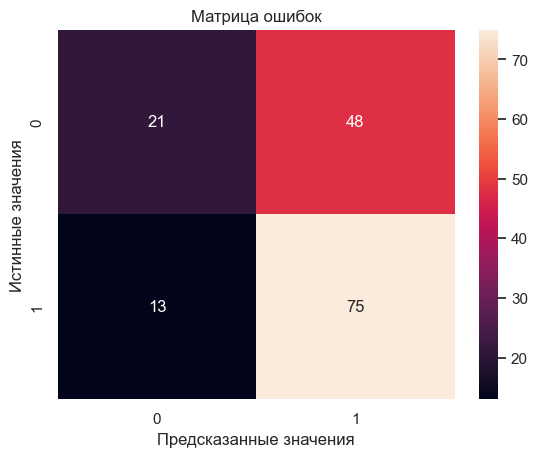

In [189]:
# выведем на экран матрицу ошибок

cm = confusion_matrix(y_test_5, predictions_5)
sns.heatmap(cm, annot=True) 
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')

В получившейся матрице записаны все возможные результаты предсказания. В левом верхнем углу находятся истинно отрицательные предсказания или True Negative (21), в правом верхнем углу — ложноположительные предсказания или False Positive (48), в левом нижнем углу — ложнонегативные предсказания или False Negative (13), и, наконец, в правом нижнем углу находятся истинно положительные предсказания или True Positive (75)

При интерпритации матрицы ошибок важно определить, какой вариант классифицикации является не приоритетным, а какой допускать точно нельзя. Целевым признаком в этой модели является вкус молока; для бизнеса худшим будет являться тот вариант, когда модель будет невкусному молоку присваивать вкусность, при этом, если фермер приобретёт корову, для которой модель предсказала невкусное молоко, а оно на самом деле окажется вкусным, то это будет не критично. Таким образом, нельзя допускать ошибок первого рода, т.е. ложнопозитивных

Метрика Accuracy показывает, скольким объектам модель смогла правильно присвоить класс. Поэтому, если признак не влияет на целевой, — он не влияет и на точность модели. Эта метрика измеряет только общую точность модели и не позволяет анализировать долю ошибочных прогнозов у каждого класса. В нашем случае значение Accuracy говорит о том, что модель правильно классифицирует примерно 61% объектов

Precision показывает точность, с которой модель присваивает объектам класс 1, то есть получает результат типа Positive. Иными словами, Precision определяет, не слишком ли часто модель выставляет класс 1 объектам класса 0. Видим, что модель верно предсказывает объекты типа Positive примерно в 61% случаев

Recall же является обратной метрикой Precision и измеряет, смогла ли модель классификации присвоить класс 1 всем объектам этого класса. Предсказания False Negative рассматриваются метрикой как «неучтённые» True Positive. Значение Recall здесь показывает, что модель верно распознала 85% всех объектов типа Positive

Необходимо исключить ошибки первого рода и настроить модель так, чтобы класс 1 она всегда предсказывала верно. Для этого улучшим метрику Precision, изменив вероятность принадлежности к положительному классу

Модель логистической регрессии не сразу присваивает объектам метки классов. Сначала она оценивает вероятность, с которой объект принадлежит к классу 1, а затем соотносит полученное значение с порогом разделения на классы. По умолчанию модель относит все предсказания с оценкой 0.5 и выше к классу 1, а ниже — к классу 0

Добавим пороги с помощью функции linspace(). Посмотрим на то, как модель будет работать при 20 разных порогах

In [190]:
# добавим пороги

thresholds = [round(i,2) for i in np.linspace(0.1, 1, num=20, endpoint=False)]

columns = ['y_pred_' + str(i) for i in thresholds]
data = pd.DataFrame(columns=['y_valid', 'y_proba'] + columns)

y_proba = clf.predict_proba(X_test_5)[:,1]
data['y_valid'] = y_test_5
data['y_proba'] = y_proba

for i, col in enumerate(columns):
    threshold = thresholds[i]
    data[col] = data['y_proba'].apply(lambda x: 1 if x >= threshold else 0)
    print('Порог:', threshold, ' | Precision:', precision_score(y_test_5, data[col], zero_division=1))

Порог: 0.1  | Precision: 0.5605095541401274
Порог: 0.15  | Precision: 0.5605095541401274
Порог: 0.19  | Precision: 0.5605095541401274
Порог: 0.24  | Precision: 0.5641025641025641
Порог: 0.28  | Precision: 0.567741935483871
Порог: 0.32  | Precision: 0.5686274509803921
Порог: 0.37  | Precision: 0.5771812080536913
Порог: 0.42  | Precision: 0.60431654676259
Порог: 0.46  | Precision: 0.6015037593984962
Порог: 0.5  | Precision: 0.6097560975609756
Порог: 0.55  | Precision: 0.6355140186915887
Порог: 0.6  | Precision: 0.6785714285714286
Порог: 0.64  | Precision: 0.684931506849315
Порог: 0.68  | Precision: 0.7272727272727273
Порог: 0.73  | Precision: 0.7692307692307693
Порог: 0.77  | Precision: 0.875
Порог: 0.82  | Precision: 1.0
Порог: 0.86  | Precision: 1.0
Порог: 0.91  | Precision: 1.0
Порог: 0.96  | Precision: 1.0


Видим, что при пороге классификации *0.82* метрика **Precision** будет равна единице, а значит, при таком пороге она верно присваивает класс 1 во всех случаях

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]

Accuracy: 0.445859872611465
Recall: 0.011363636363636364



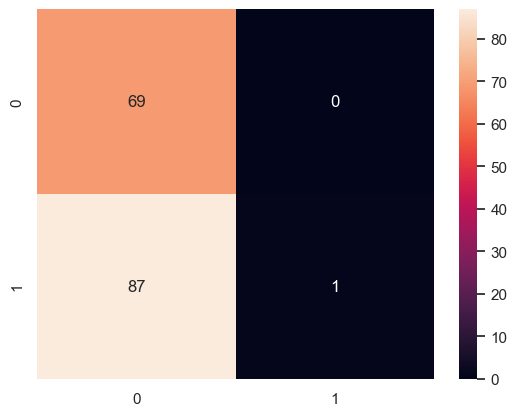

In [191]:
# применим функцию classification_threshold, установив порог классификации 0.82

classification_threshold(0.82)

Количество ошибок первого рода равно 0, но при этом точность модели согласно метрике Accuracy снизилась до 44%. Попробуем посмотреть на результат с более низкими порогами

Predictions: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0]

Accuracy: 0.5159235668789809
Recall: 0.1590909090909091



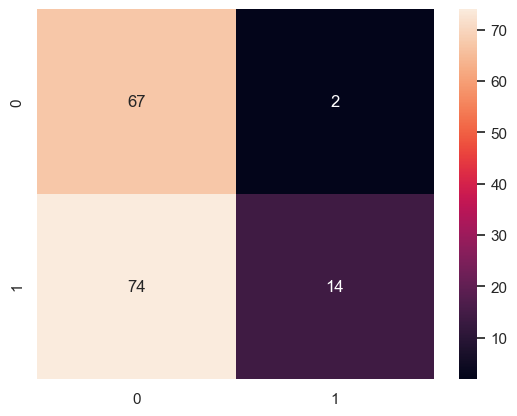

In [192]:
# установим порог классификации 0.77

classification_threshold(0.77)

Хотя точность Accuracy повысилась, результат всё равно является неудовлетворительным

Predictions: [0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0
 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0
 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1
 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1
 0 1 1 1 1 1 1 0 0]

Accuracy: 0.6305732484076433
Recall: 0.6136363636363636



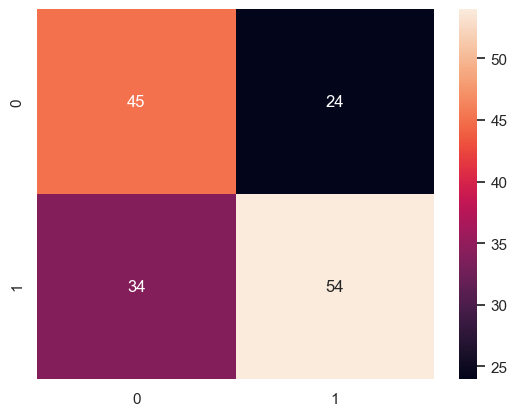

In [193]:
# установим порог классификации 0.62

classification_threshold(0.62)

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Количество критических ошибок снизилось с 48 (при стандартном пороге) до 24, а изначальная точность в 61% выросла до 63%. Порог классификации в 0.62 дал хороший результат, можно приступить к применению модели
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Применение модели логистической регресии
</div>

---

Применим получившуюся модель логистической регрессии с порогом классификации 0.62 к данным о коровах на покупку

In [194]:
# создадим копию таблицы

cow_buy_copy_2 = cow_buy_copy.copy()

In [195]:
# запишем названия категориальных и количественных признаков в переменные cat_col_names_6 и num_col_names_6

cat_col_names_6 = ['age', 'breed', 'pasture_type', 'dad_breed', 'dad_name']
num_col_names_6 = ['mean_eke', 'mean_raw_protein', 'current_fat_percent', 'current_protein_percent', 'mean_spo', ]

In [196]:
# запишем названия признаков, которые не являются входными

columns_to_drop_6 = ['milk_amount_predicted']

In [197]:
# удалим из таблицы целевой признак

cow_buy_copy_2 = cow_buy_copy_2.drop(columns_to_drop_6, axis=1)

In [198]:
# инициализируем методы масштабирования и кодирования

encoder_6 = OneHotEncoder(drop='first', sparse=False)
scaler_6 = StandardScaler()

In [199]:
# преобразуем категориальные признаки в числовые с помощью кодирования OneHotEncoding

cow_buy_copy_2_ohe = encoder_6.fit_transform(cow_buy_copy_2[cat_col_names_6])

In [200]:
# получим из кодировщика список новых признаков

encoder_col_names_6 = encoder_6.get_feature_names_out()

In [201]:
# проверим результат

print(f'Обновлённый список признаков: {encoder_col_names_6}')

Обновлённый список признаков: ['age_менее_2_лет' 'breed_Соверин' 'pasture_type_Холмистое'
 'dad_breed_Соверин' 'dad_name_Буйный' 'dad_name_Геркулес'
 'dad_name_Соловчик']


In [202]:
# масштабируем числовые признаки с помощью StandardScaler

cow_buy_copy_2_scaled = scaler_6.fit_transform(cow_buy_copy_2[num_col_names_6])

In [203]:
# превратим получившиеся матрицы в датафреймы

cow_buy_copy_2_ohe = pd.DataFrame(cow_buy_copy_2_ohe, columns=encoder_col_names_6)
cow_buy_copy_2_scaled = pd.DataFrame(cow_buy_copy_2_scaled, columns=num_col_names_6)

In [204]:
# объединим категориальные и количественные данные

cow_buy_copy_2 = pd.concat([cow_buy_copy_2_ohe, cow_buy_copy_2_scaled], axis=1)

In [205]:
# выполним предсказание вероятностей классов

proba_6 = clf.predict_proba(cow_buy_copy_2)[:, 1]

In [206]:
# устанавливаем порог

threshold = 0.62

In [207]:
# применbv порог для определения предсказания

predictions_6 = np.where(proba_6 >= threshold, 1, 0)

In [208]:
# создадим столбец с предсказанным вкусом молока

cow_buy_copy['is_tasty_predicted'] = predictions_6

In [209]:
# посмотрим на тех коров, чьё молоко будет вкусным

cow_buy_copy[(cow_buy_copy['is_tasty_predicted'] == 1)]

,breed,pasture_type,dad_breed,dad_name,current_fat_percent,current_protein_percent,age,mean_spo,mean_eke,mean_raw_protein,milk_amount_predicted,is_tasty_predicted
0,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.958744,15.276162,2019.947532,6494.942591,1
2,Соверин,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.958744,15.276162,2019.947532,6169.023069,1
3,Соверин,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.958744,15.276162,2019.947532,6478.112671,1
9,Соверин,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.958744,15.276162,2019.947532,6285.563962,1
13,Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,0.958744,15.276162,2019.947532,6012.498036,1
15,Соверин,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,0.958744,15.276162,2019.947532,6478.112671,1
16,Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,0.958744,15.276162,2019.947532,6229.731154,1


In [210]:
# сравним с данными, полученными после применения модели линейной регрессии

cow_buy_copy[(cow_buy_copy['milk_amount_predicted'] > 6000)]

,breed,pasture_type,dad_breed,dad_name,current_fat_percent,current_protein_percent,age,mean_spo,mean_eke,mean_raw_protein,milk_amount_predicted,is_tasty_predicted
0,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.958744,15.276162,2019.947532,6494.942591,1
1,Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.958744,15.276162,2019.947532,6263.734322,0
2,Соверин,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.958744,15.276162,2019.947532,6169.023069,1
3,Соверин,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.958744,15.276162,2019.947532,6478.112671,1
4,Соверин,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.958744,15.276162,2019.947532,6427.169360,0
5,Соверин,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,0.958744,15.276162,2019.947532,6310.403512,0
7,Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,0.958744,15.276162,2019.947532,6456.283031,0
9,Соверин,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.958744,15.276162,2019.947532,6285.563962,1
10,Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,0.958744,15.276162,2019.947532,6229.731154,0
11,Соверин,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.958744,15.276162,2019.947532,6502.952220,0


Видим, что у всех коров, чьё молоко определено как вкусное, удой составляет от 6000 кг и выше

In [211]:
# объединим результаты

final_df = cow_buy_copy[(cow_buy_copy['milk_amount_predicted'] > 6000) & (cow_buy_copy['is_tasty_predicted']==1)]
final_df

,breed,pasture_type,dad_breed,dad_name,current_fat_percent,current_protein_percent,age,mean_spo,mean_eke,mean_raw_protein,milk_amount_predicted,is_tasty_predicted
0,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.958744,15.276162,2019.947532,6494.942591,1
2,Соверин,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.958744,15.276162,2019.947532,6169.023069,1
3,Соверин,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.958744,15.276162,2019.947532,6478.112671,1
9,Соверин,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.958744,15.276162,2019.947532,6285.563962,1
13,Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,0.958744,15.276162,2019.947532,6012.498036,1
15,Соверин,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,0.958744,15.276162,2019.947532,6478.112671,1
16,Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,0.958744,15.276162,2019.947532,6229.731154,1


---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Общий вывод
</div>

---

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

В ходе предобработки из данных были удалены явные дубликаты, заменены неявные дубликаты; исправлены разные написания одинаковых пород в столбцах breed и dad_breed. Пропусков ни в одной таблице обнаружено не было. Изучено числовое описание данных в таблицах, найдена и устранена аномалия в столбце milk_amount. Построены графики для описания признаков в каждой из таблиц
    
</div>

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Корреляционный анализ исходных данных о коровах заказчика из таблицы `ferma_main` показал, что сильнее всего целевой признак (размер удоя) положительно коррелирует с показателем питательности корма (ЭКЕ), с его сахаро-протеиновым соотношением (СПО) и жирностью удоя

Для предсказания годового удоя коров на покупку были обучены три модели линейной регрессии. Для изложения результатов обучения этих моделей будем использовать лишь одну метрику из четырёх вычисленных — коэффициент детерминации или R2.

Так, коэффициент детерминации первой модели составил 0.7844. Это число показывает, в скольких процентах случаев предсказание модели точнее, чем просто вычисление среднего значения целевого признака. Этот результат говорит о том, что полученная модель даёт предсказания более точные, чем среднее значение целевого признака в 78.44% случаев. Анализ остатков показал, что эта модель даёт завышенные предсказания

При построении второй модели линейной регрессии была учтена нелинейная зависимость между целевым признаком и признаком СПО (сахаро-протеиновое соотношение корма). После исключения нелинейности коэффициент детерминации второй модели повысился до 81.8%. Распределение остатков стало более равномерным

Для обучения третьей модели в данные был включён новый признак — имя папы-быка из таблицы `ferma_dad`, также было учтено преобразование нелинейности во второй модели. Благодаря этому удалось повысить коэффициент детерминации до 82.47%
    
</div>

Ниже приведён полный список вычисленных для моделей линейной регресии метрик:

**Первая модель**:
- `MSE`: 43887.015009660514
- `RMSE`: 209.4922791170608
- `MAE`: 164.2419446347493
- `R2`: 0.7844078173416966

**Вторая модель**:
- `MSE`: 37030.91131113693
- `RMSE`: 192.43417396901447
- `MAE`: 149.03965222364602
- `R2`: 0.8180879926867503

**Третья модель**:
- `MSE`: 35673.88988618199
- `RMSE`: 188.87532895055932
- `MAE`: 146.16302445362328
- `R2`: 0.8247542745210403

Чем ближе значение таких метрик, как MSE, RMSE и MAE к нулю, тем точнее работает модель. Лучше всего себя показала третья модель, что подтвердил анализ остатков

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Для решения задачи бинарной классификации — предсказания признака `is_tasty`, то есть, вкуса молока — была выбрана модель логистической регрессии. Для первичной оценки результатов обучения были рассчитаны метрики Accuracy, Precision и Recall. 

В ходе рассуждения было принято решение исключить ошибки первого рода как самые критичные для задачи и настроить модель так, чтобы класс 1 (молоко вкусное) она всегда предсказывала верно. Для этого, с помощью изменения порога вероятности принадлежности к положительному классу, была улучшена метрика Precision. Так, количество критических ошибок снизилось с 48 (при стандартном пороге) до 24, а изначальная точность в 61% выросла до 63%. Порог классификации в 0.62 дал хороший результат
    
</div>

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Неизвестно, скольких коров фермер планирует приобрести. Подходящими для покупки являются коровы под номерами 0, 2, 3, 7, 11, 12 и 13, так как модель определила у них удой выше 6000 кг и вкусное молоко. Данные об этих коровах хранятся в таблице final_df. Наименьший риск имеет покупка коров под номерами 0, 3, 7 и 12, так как их удой составил больше 6500 кг. При этом самыми молодыми (возрастом менее 2 лет) являются номера 7 и 11. Для улучшения построенных моделей можно увеличить количество данных, сделав запрос заказчику, а также внедрить в данные новые признаки, которые имеют отношение к корму коров и их здоровью
    
</div>